In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
#from pandas_profiling import ProfileReport
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
#from yellowbrick.model_selection import FeatureImportances
#import shap
import joblib
%matplotlib inline

import optuna
import mlflow

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

pd.set_option('display.float_format', '{:.6f}'.format)

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

### Feature-wise Preprocessing Strategy

- Customer ID: Remove the feature as it serves only as an identifier.

- Name: Drop the feature since it has no predictive relevance.

- Gender: Apply one-hot encoding and impute missing values using the mode.

- Age: Scale using Min–Max normalization.

- Income: Apply Min–Max scaling, handle outliers, correct skewness, and impute missing values using the median.

- Income Stability: Use one-hot encoding and replace missing values with the mode.

- Profession: Apply one-hot encoding and remove rows corresponding to rare professions (e.g., Student, Businessman, Unemployed).

- Type of Employment: Drop the feature due to limited predictive contribution.

- Location: Encode using one-hot encoding.

- Loan Amount Requested: Apply Min–Max scaling, handle outliers, and correct skewness.

- Current Loan Expenses: Handle placeholder values (e.g., -999), apply Min–Max scaling, treat outliers, impute missing values using the median, and fix skewness.

- Expense Type 1: Apply one-hot encoding.

- Expense Type 2: Apply one-hot encoding.

- Dependents: Handle outliers and impute missing values using the mode.

- Credit Score: Apply Min–Max scaling and impute missing values using the mean or median.

- Number of Defaults: No preprocessing required.

- Has an Active Credit Card: Apply one-hot encoding and replace missing values with the mode.

- Property ID: Drop the feature as it is a non-informative identifier.

- Property Age: Apply Min–Max scaling, handle outliers, correct skewness, and impute missing values using the median.

- Property Type: No preprocessing required.

- Property Location: Apply one-hot encoding and impute missing values using the mode.

- Co-applicant: Handle placeholder values (e.g., -999).

- Property Price: Handle placeholder values (-999), apply Min–Max scaling, treat outliers, and correct skewness.

- Loan Sanction Amount (Target Variable): Handle placeholder values (-999) and drop rows with missing target values.


In [44]:
df = pd.read_csv(r'C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\data\loan_processed_data.csv')

df.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),loan_approval
0,C-36995,Frederica Shealy,F,56,1933.050000,Low,Working,Sales staff,Semi-Urban,72809.580000,241.080000,N,N,3.000000,809.440000,0,NaN,746,1933.050000,4,Rural,1,119933.460000,54607.180000,approved
1,C-33999,America Calderone,M,32,4952.910000,Low,Working,NaN,Semi-Urban,46837.470000,495.810000,N,Y,1.000000,780.400000,0,Unpossessed,608,4952.910000,2,Rural,1,54791.000000,37469.980000,approved
2,C-3770,Rosetta Verne,F,65,988.190000,High,Pensioner,NaN,Semi-Urban,45593.040000,171.950000,N,Y,1.000000,833.150000,0,Unpossessed,546,988.190000,2,Urban,0,72440.580000,36474.430000,approved
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.920000,298.540000,N,Y,2.000000,832.700000,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.510000,56040.540000,approved
4,C-23459,Afton Venema,F,31,2614.770000,Low,Working,High skill tech staff,Semi-Urban,113858.890000,491.410000,N,Y,NaN,745.550000,1,Active,715,2614.770000,4,Semi-Urban,1,208567.910000,74008.280000,approved


In [45]:
# Find duplicate columns
duplicate_cols = df.columns[df.T.duplicated()]

print("Duplicate columns:", duplicate_cols.tolist())

Duplicate columns: []


In [46]:
df.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)', 'loan_approval'],
      dtype='object')

### Feature Drops

In [47]:
df.drop(columns=['Customer ID', 'Name','Type of Employment','Property ID'], inplace=True)

df.head()

,Gender,Age,Income (USD),Income Stability,Profession,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),loan_approval
0,F,56,1933.050000,Low,Working,Semi-Urban,72809.580000,241.080000,N,N,3.000000,809.440000,0,NaN,1933.050000,4,Rural,1,119933.460000,54607.180000,approved
1,M,32,4952.910000,Low,Working,Semi-Urban,46837.470000,495.810000,N,Y,1.000000,780.400000,0,Unpossessed,4952.910000,2,Rural,1,54791.000000,37469.980000,approved
2,F,65,988.190000,High,Pensioner,Semi-Urban,45593.040000,171.950000,N,Y,1.000000,833.150000,0,Unpossessed,988.190000,2,Urban,0,72440.580000,36474.430000,approved
3,F,65,NaN,High,Pensioner,Rural,80057.920000,298.540000,N,Y,2.000000,832.700000,1,Unpossessed,NaN,2,Semi-Urban,1,121441.510000,56040.540000,approved
4,F,31,2614.770000,Low,Working,Semi-Urban,113858.890000,491.410000,N,Y,NaN,745.550000,1,Active,2614.770000,4,Semi-Urban,1,208567.910000,74008.280000,approved


In [48]:
tdf, vdf = train_test_split(df, test_size=0.2, random_state=42)

In [49]:
tdf.shape

(24000, 21)

In [50]:
vdf.shape

(6000, 21)

In [51]:
# missing values imputer

tdf1 = tdf.copy()
vdf1 = vdf.copy()


def impute_data(df):
    # Create a copy to avoid modifying the original dataframe unexpectedly
    df = df.copy()
    
    mode_features = ['Gender', 'Income Stability', 'Dependents', 'Has Active Credit Card', 'Property Location']
    median_features = ['Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age']
    target_col = 'Loan Sanction Amount (USD)'

    # 1. Drop rows where target is missing
    if target_col in df.columns:
        df = df.dropna(subset=[target_col])
        
    # 2. Impute with Mode
    for ft in mode_features:
        if ft in df.columns and not df[ft].mode().empty:
            df[ft] = df[ft].fillna(df[ft].mode()[0])
        
    # 3. Impute with Median
    for ft in median_features:
        if ft in df.columns:
            df[ft] = df[ft].fillna(df[ft].median())
            
    return df

df1 = impute_data(tdf1)

vdf1 = impute_data(vdf1)

In [52]:
print(df1['Gender'].value_counts())
print()
print(vdf1['Gender'].value_counts())

Gender
M    12000
F    11725
Name: count, dtype: int64

Gender
F    3000
M    2935
Name: count, dtype: int64


In [53]:
# outlier imputation

def remove_outliers_iqr(df):
    # Create a copy to prevent SettingWithCopy warnings
    df = df.copy()
    
    # Define features to check
    outlier_ft = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 
                  'Dependents', 'Property Age', 'Property Price']

    # Calculate IQR bounds
    Q1 = df[outlier_ft].quantile(0.25)
    Q3 = df[outlier_ft].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify rows that have at least one outlier in the specified columns
    is_outlier = ((df[outlier_ft] < lower_bound) | (df[outlier_ft] > upper_bound)).any(axis=1)
    
    # Filter and return the cleaned dataframe
    return df[~is_outlier]

# Usage:
df1 = remove_outliers_iqr(df1)
vdf1 = remove_outliers_iqr(vdf1)

In [54]:
df1.head()

,Gender,Age,Income (USD),Income Stability,Profession,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD),loan_approval
251,M,36,2230.820000,Low,Working,Semi-Urban,132263.080000,500.430000,N,N,1.000000,646.050000,1,Active,2231.805000,3,Urban,1,250293.240000,0.000000,not_approved
22941,M,52,2230.820000,Low,Commercial associate,Semi-Urban,112307.540000,539.090000,N,Y,1.000000,706.420000,0,Active,2231.805000,2,Rural,1,157866.230000,72999.900000,approved
618,F,18,2230.820000,Low,Working,Rural,24268.350000,168.210000,N,N,2.000000,640.230000,0,Unpossessed,2231.805000,2,Urban,1,30470.510000,0.000000,not_approved
17090,F,18,2203.520000,Low,Working,Semi-Urban,76342.040000,681.950000,N,Y,2.000000,835.550000,0,Inactive,2203.520000,3,Urban,1,142224.120000,57256.530000,approved
6362,F,18,2908.010000,Low,State servant,Rural,94826.330000,812.060000,N,Y,2.000000,761.200000,0,Unpossessed,2908.010000,2,Urban,1,145521.290000,0.000000,not_approved


In [55]:
df1.Profession.value_counts()

Profession
Working                 12044
Commercial associate     5292
Pensioner                2024
State servant            1579
Unemployed                  2
Student                     1
Name: count, dtype: int64

In [56]:
profession_list = ['Student', 'Unemployed', 'Businessman']

# Filter the dataframe to keep only rows where Profession is NOT in the list
df1 = df1[~df1['Profession'].isin(profession_list)]
vdf1 = vdf1[~vdf1['Profession'].isin(profession_list)]

print("train dataset")
print(df1.Profession.value_counts())
print()
print("validation dataset")
print(vdf1.Profession.value_counts())

train dataset
Profession
Working                 12044
Commercial associate     5292
Pensioner                2024
State servant            1579
Name: count, dtype: int64

validation dataset
Profession
Working                 3065
Commercial associate    1223
Pensioner                498
State servant            425
Name: count, dtype: int64


### Feature transformation

In [57]:
# First, ensure df1 is an independent object (run this where you create df1)

def impute_999(df):

    df = df.copy()

    features_with_999 = ['Co-Applicant', 'Current Loan Expenses (USD)', 'Loan Sanction Amount (USD)', 'Property Price']

    # Convert columns to numeric and replace -999 directly
    for col in features_with_999:
        df[col] = pd.to_numeric(df[col], errors='coerce').replace(-999, 0)

    # Verify
    return df

df1 = impute_999(df1)
vdf1 = impute_999(vdf1)

print("train dataset")
print(df1['Co-Applicant'].value_counts())
print()
print("validation dataset")
print(vdf1['Co-Applicant'].value_counts())

train dataset
Co-Applicant
1    17741
0     3198
Name: count, dtype: int64

validation dataset
Co-Applicant
1    4443
0     768
Name: count, dtype: int64


### Min max scaling

In [58]:
# 1. Define columns
scale_cols = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age', 'Property Price']

# 2. Scale the data directly
scaler = MinMaxScaler()
df1[scale_cols] = scaler.fit_transform(df1[scale_cols])
vdf1[scale_cols] = scaler.transform(vdf1[scale_cols])

In [59]:
cols = ['Gender', 'Profession', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Income Stability']

for col in cols:
    print(df1[col].value_counts())
    print()

Gender
M    10607
F    10332
Name: count, dtype: int64

Profession
Working                 12044
Commercial associate     5292
Pensioner                2024
State servant            1579
Name: count, dtype: int64

Location
Semi-Urban    15299
Rural          3875
Urban          1765
Name: count, dtype: int64

Expense Type 1
N    13815
Y     7124
Name: count, dtype: int64

Expense Type 2
Y    14008
N     6931
Name: count, dtype: int64

Has Active Credit Card
Active         7819
Inactive       6679
Unpossessed    6441
Name: count, dtype: int64

Property Location
Semi-Urban    7455
Rural         7009
Urban         6475
Name: count, dtype: int64

Income Stability
Low     19040
High     1899
Name: count, dtype: int64



In [60]:
def encoder(df):
    df = df.copy()


    binary_cols = ['Gender', 'Expense Type 1', 'Expense Type 2', 'Income Stability', 'loan_approval']

    ohe_cols = ['Profession', 'Location','Has Active Credit Card', 'Property Location']

    le = LabelEncoder()

    for col in binary_cols:
        df[col] = le.fit_transform(df[col])

    df = pd.get_dummies(df, columns=ohe_cols, drop_first=True, dtype=int)

    return df

df1 = encoder(df1)

vdf1 = encoder(vdf1)

In [61]:
df1.head()

,Gender,Age,Income (USD),Income Stability,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD),loan_approval,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban
251,1,0.382979,0.447737,1,0.542535,0.524413,0,0,1.000000,0.208847,1,0.447975,3,1,0.702683,0.000000,1,0,0,1,1,0,0,0,0,1
22941,1,0.723404,0.447737,1,0.456756,0.567857,0,1,1.000000,0.399734,0,0.447975,2,1,0.443200,72999.900000,0,0,0,0,1,0,0,0,0,0
618,0,0.000000,0.447737,1,0.078319,0.151086,0,0,2.000000,0.190445,0,0.447975,2,1,0.085544,0.000000,1,0,0,1,0,0,0,1,0,1
17090,0,0.000000,0.441137,1,0.302158,0.728393,0,1,2.000000,0.808038,0,0.441137,3,1,0.399286,57256.530000,0,0,0,1,1,0,1,0,0,1
6362,0,0.000000,0.611448,1,0.381613,0.874602,0,1,2.000000,0.572946,0,0.611448,2,1,0.408542,0.000000,1,0,1,0,0,0,0,1,0,1


In [62]:
vdf1.head()

,Gender,Age,Income (USD),Income Stability,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD),loan_approval,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban
2308,1,0.638298,0.544653,1,0.255409,0.545888,1,1,4.000000,0.210681,0,0.544653,3,1,0.202447,0.000000,1,0,0,1,1,0,0,1,0,1
22404,0,0.851064,0.983174,1,0.355909,0.403600,1,1,3.000000,0.383134,0,0.983174,1,1,0.298762,62192.620000,0,0,0,0,0,1,0,1,1,0
23397,1,0.148936,0.291941,1,0.587770,0.500860,0,1,2.000000,0.296971,1,0.291941,4,1,0.508645,99950.540000,0,0,0,0,1,0,1,0,0,1
25058,0,0.000000,0.438882,1,0.486863,0.449303,0,1,3.000000,0.095902,0,0.438705,2,1,0.599248,0.000000,1,0,0,0,1,0,1,0,0,0
2664,0,0.382979,0.293234,1,0.181935,0.233063,0,1,3.000000,0.468254,0,0.293234,4,1,0.208033,0.000000,1,0,0,1,1,0,0,1,0,0


In [63]:
def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    match feature:
        case 'Property Age':
            fig, ax = plt.subplots(figsize=(18, 10))
            sns.histplot(df[feature]/365.25, bins=the_bins, kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [ ]:
# 1. Define columns
def skew_correction(df, function):
    df = df.copy()
    skewed_cols = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Property Age']

    # 2. Apply cube root transformation directly
    df[skewed_cols] = function(df[skewed_cols])

    for col in skewed_cols:
        create_hist_plot(df, col)

df2 = df1.copy()

vdf2 = vdf1.copy()

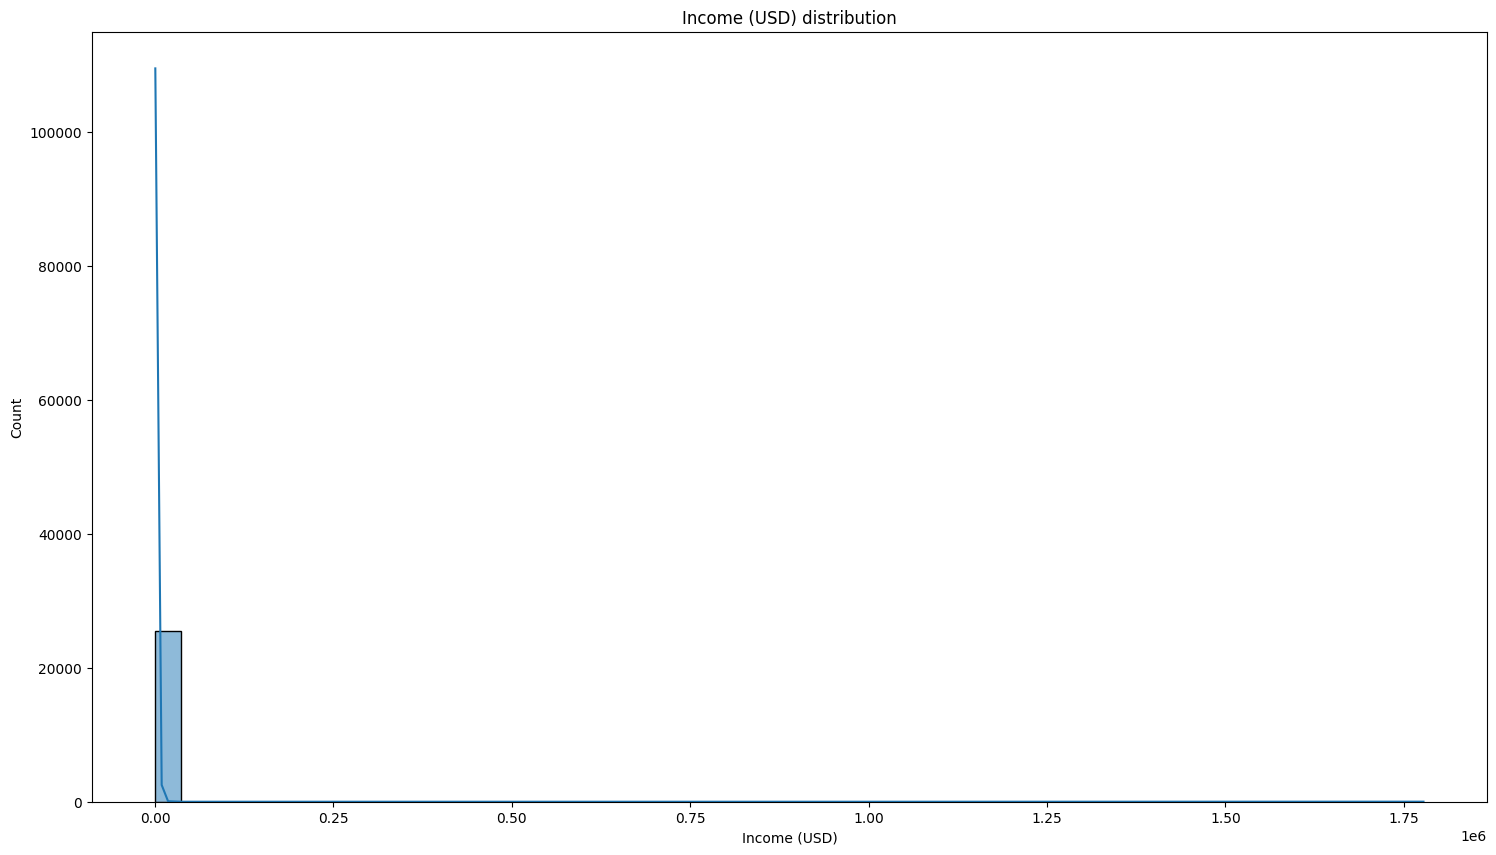

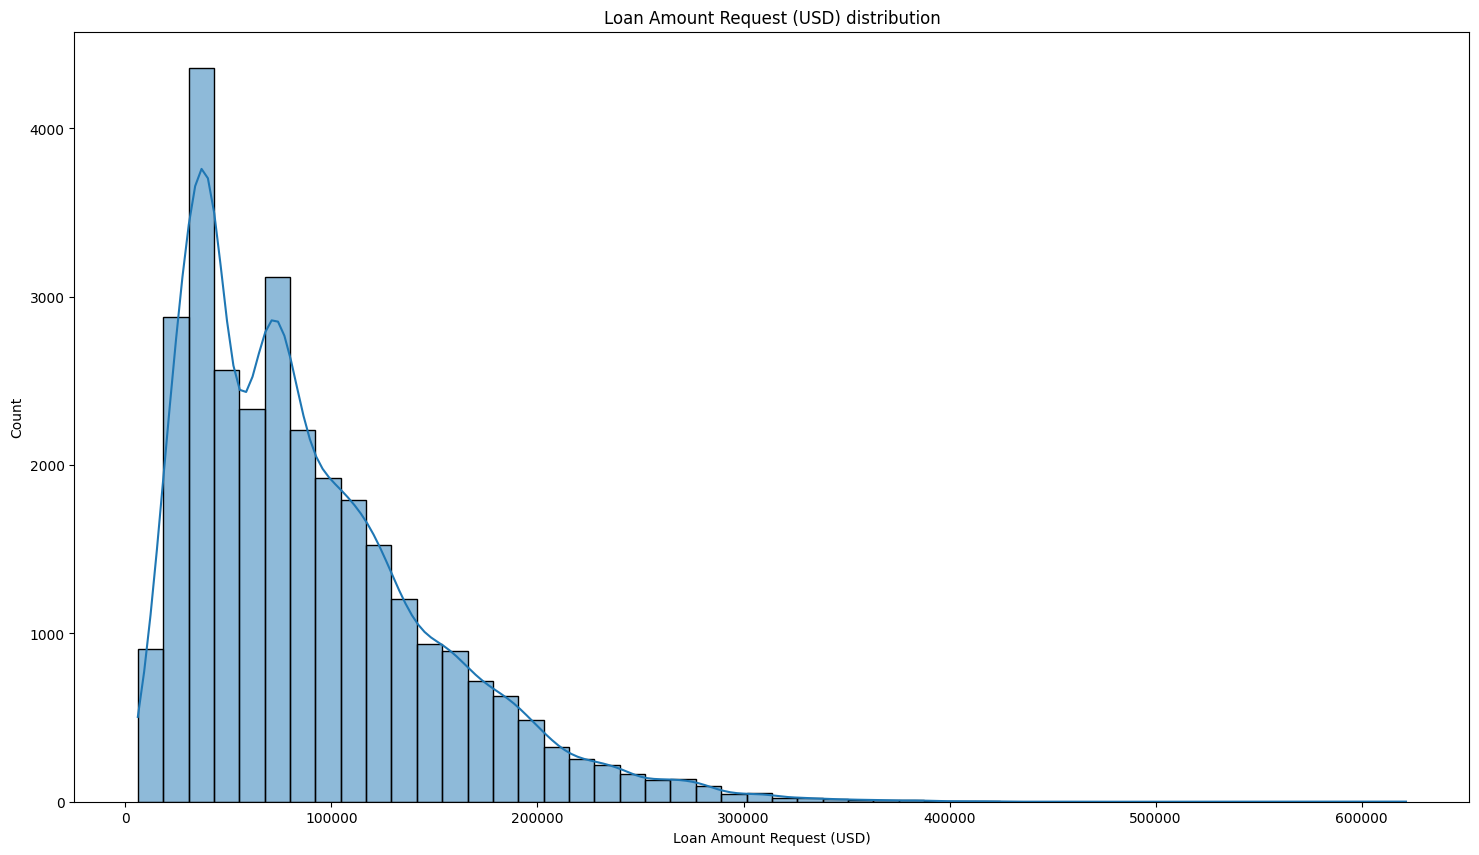

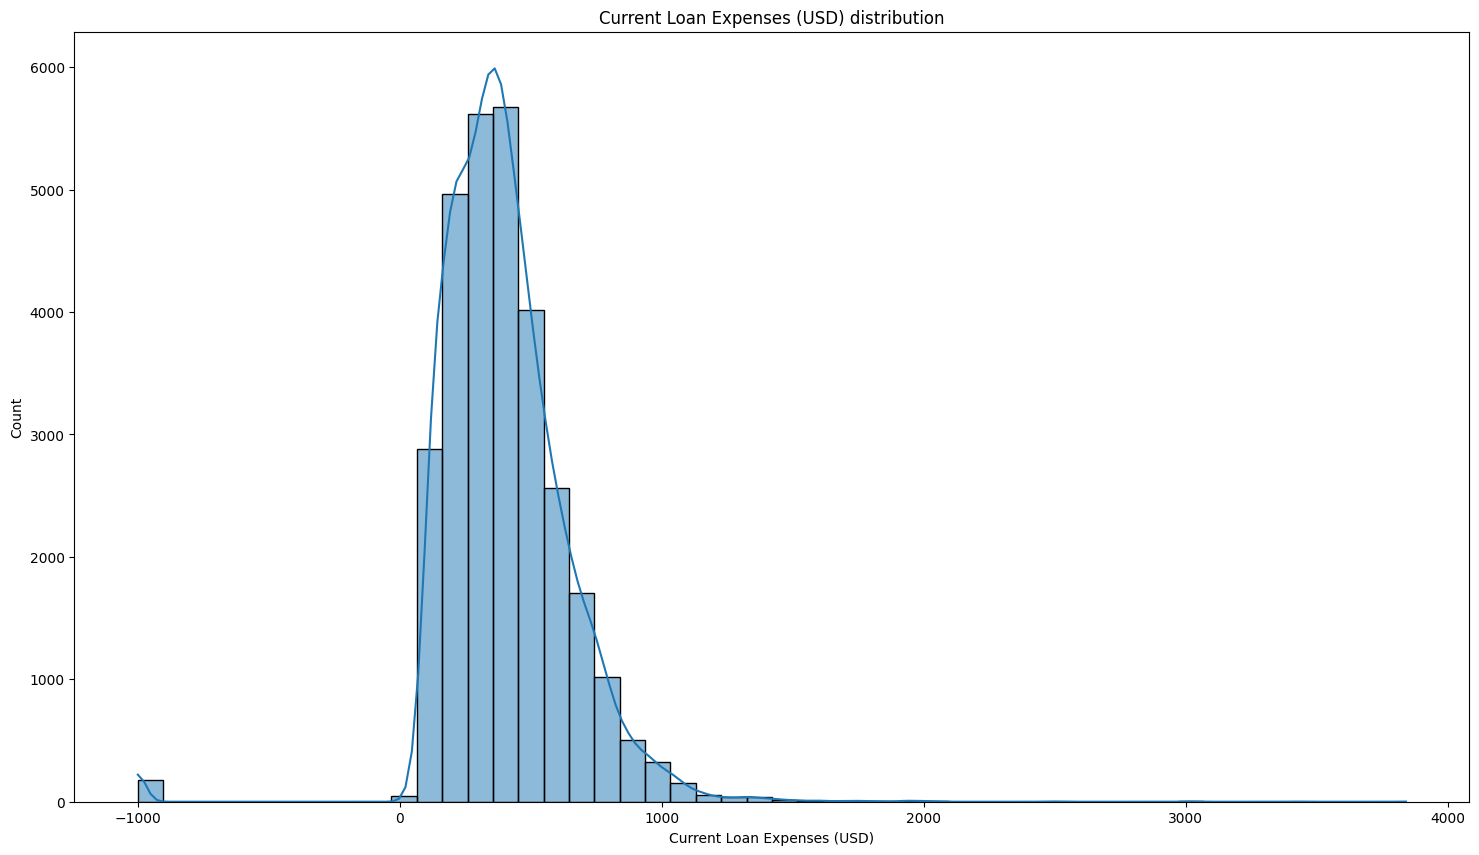

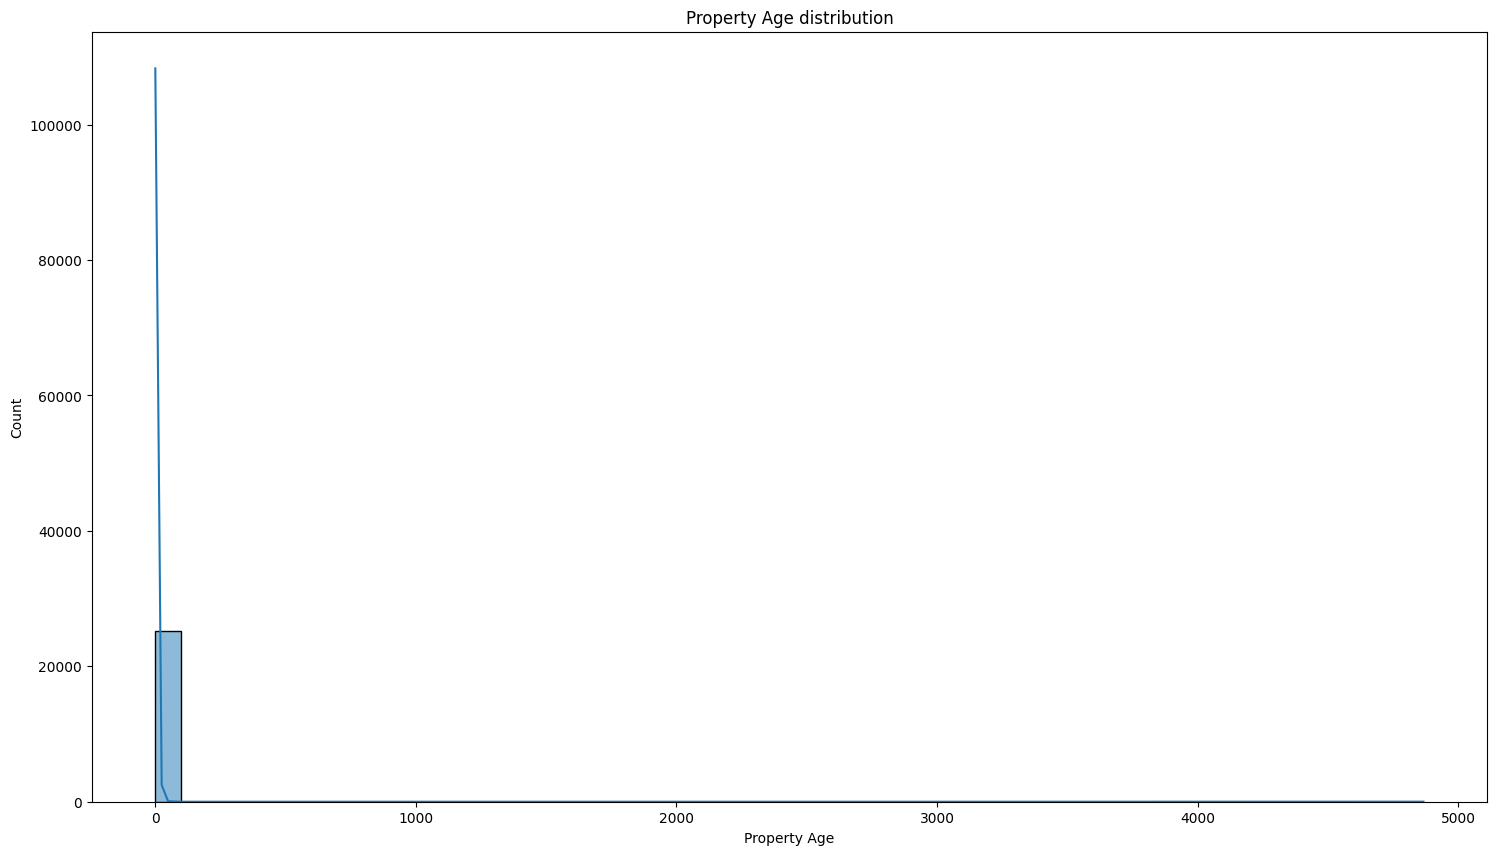

In [65]:
skewed_cols = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Property Age']

for col in skewed_cols:
    create_hist_plot(df, col)

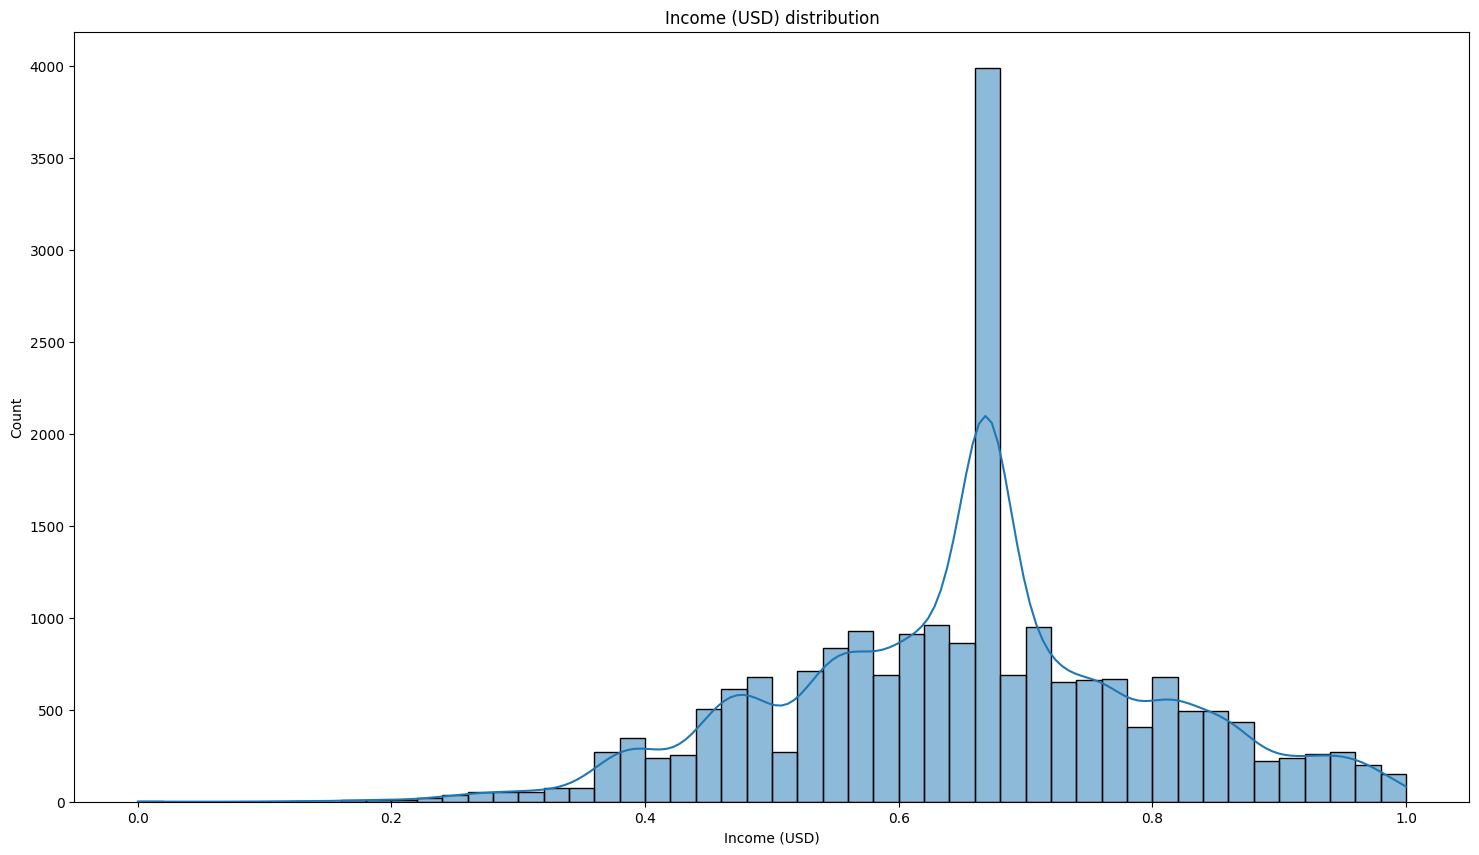

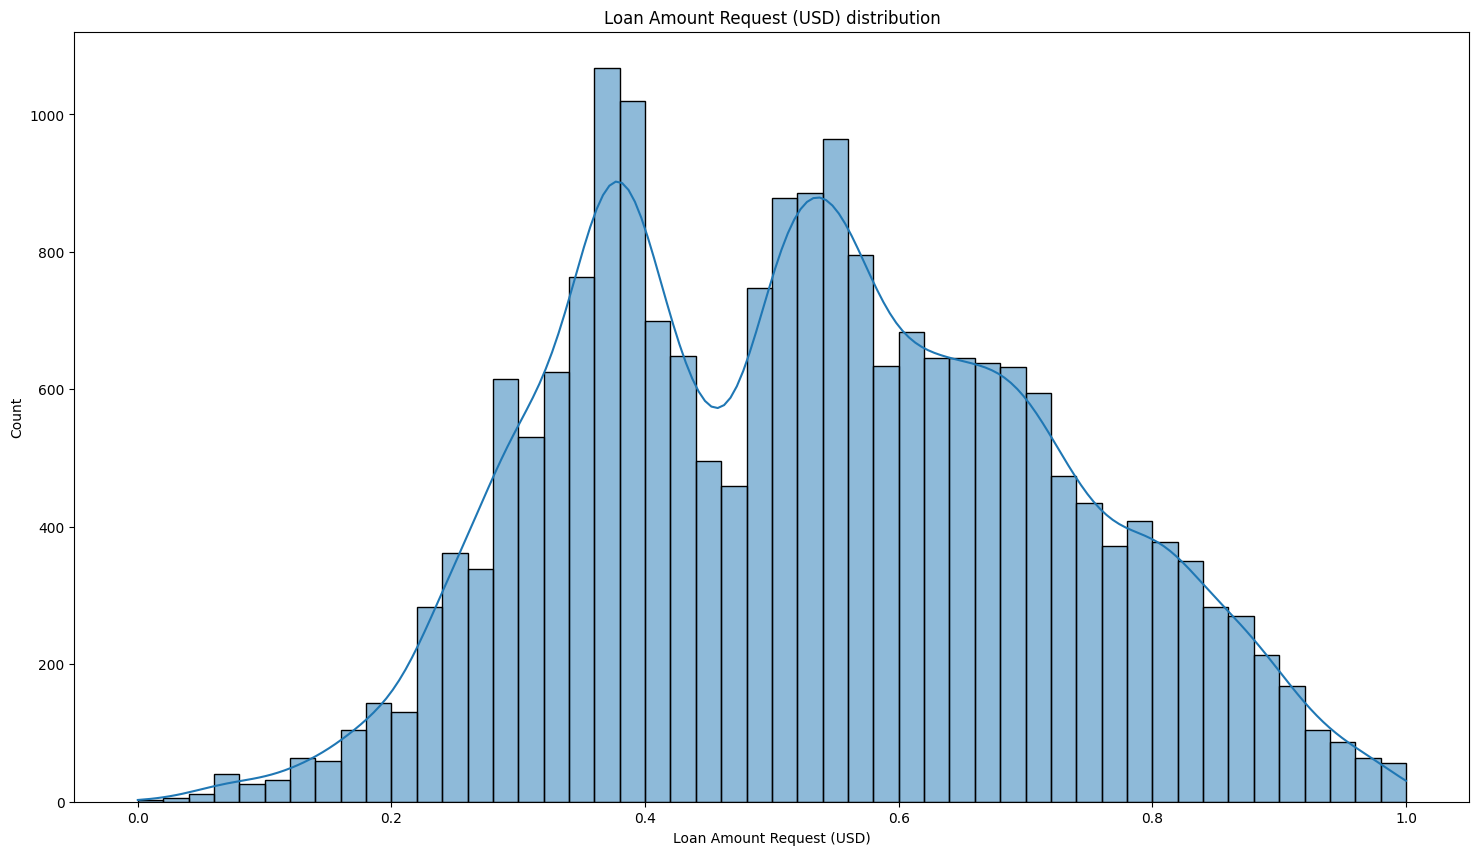

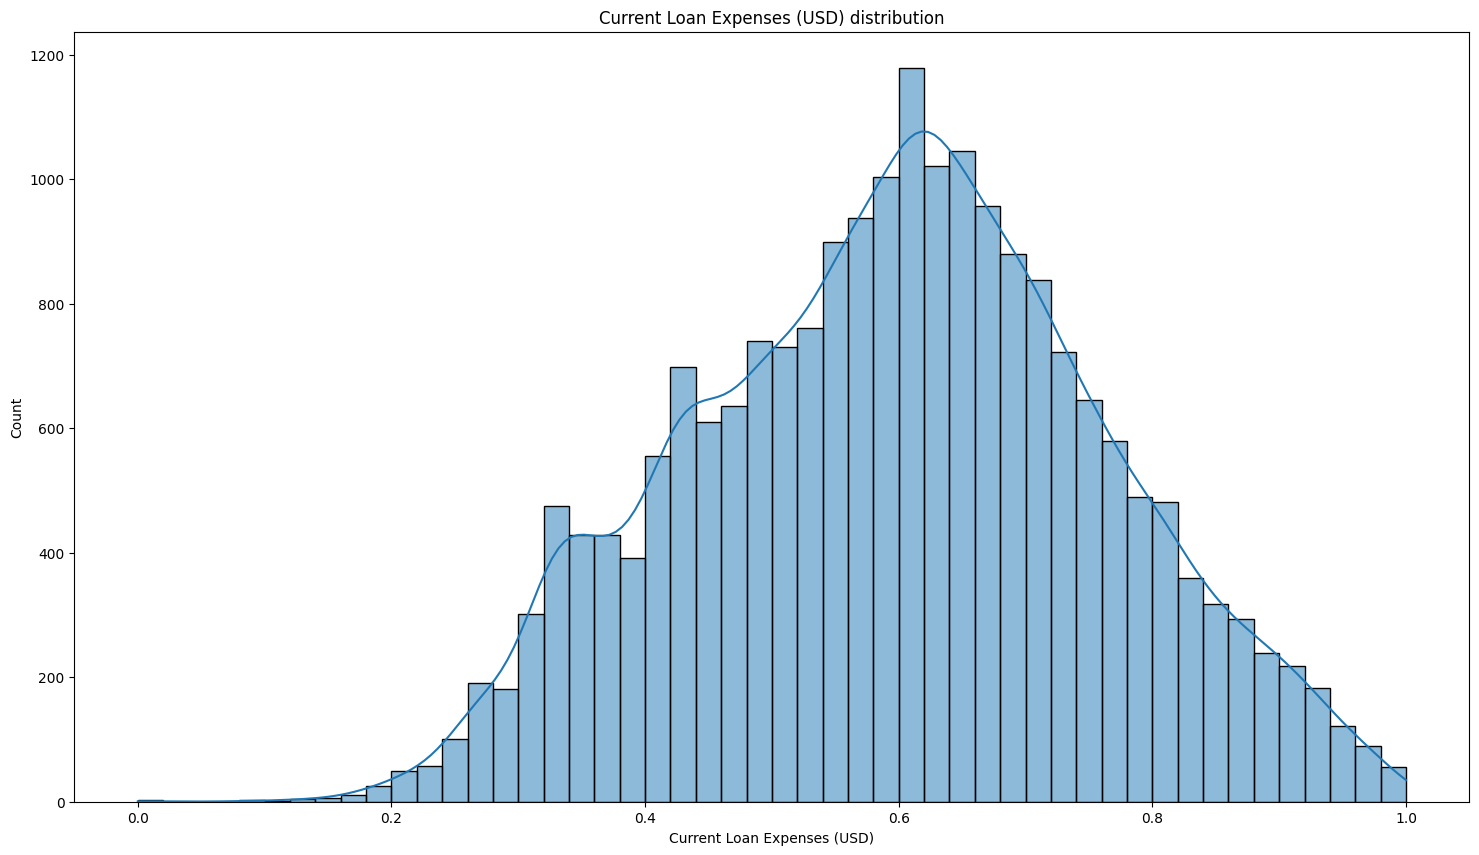

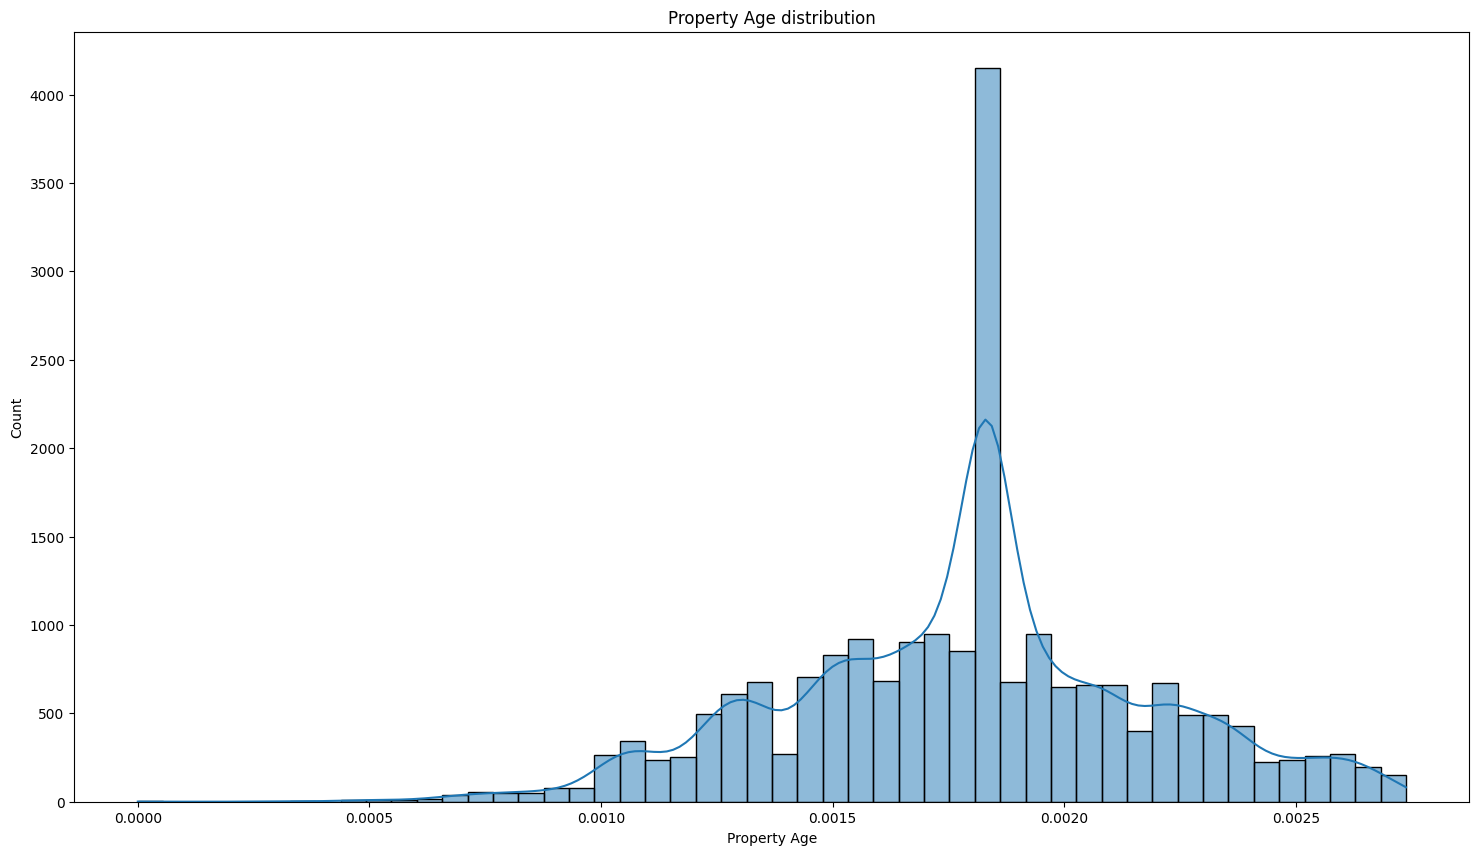

In [66]:
skew_correction(df2, np.sqrt)

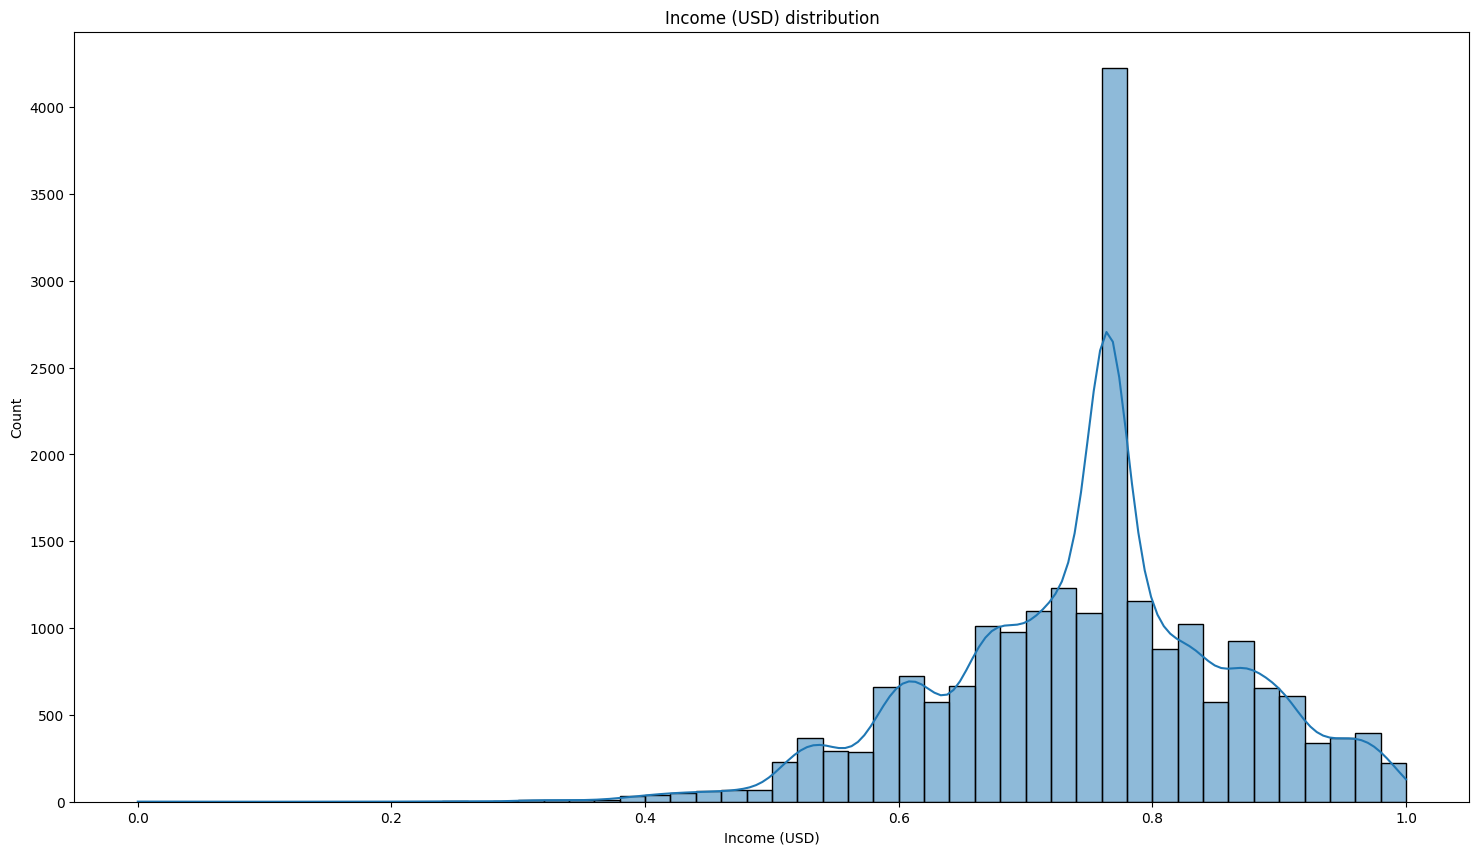

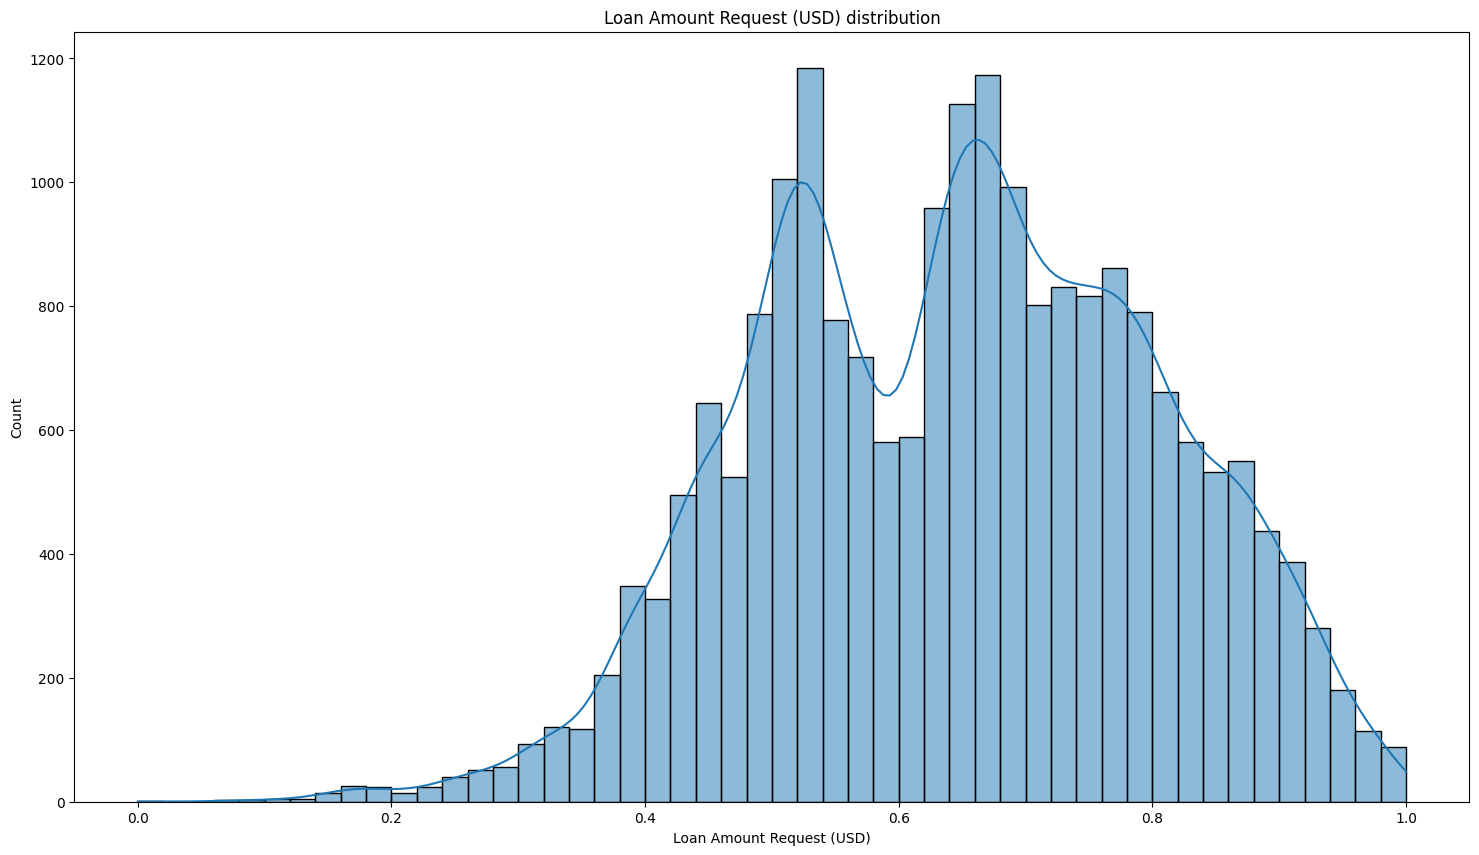

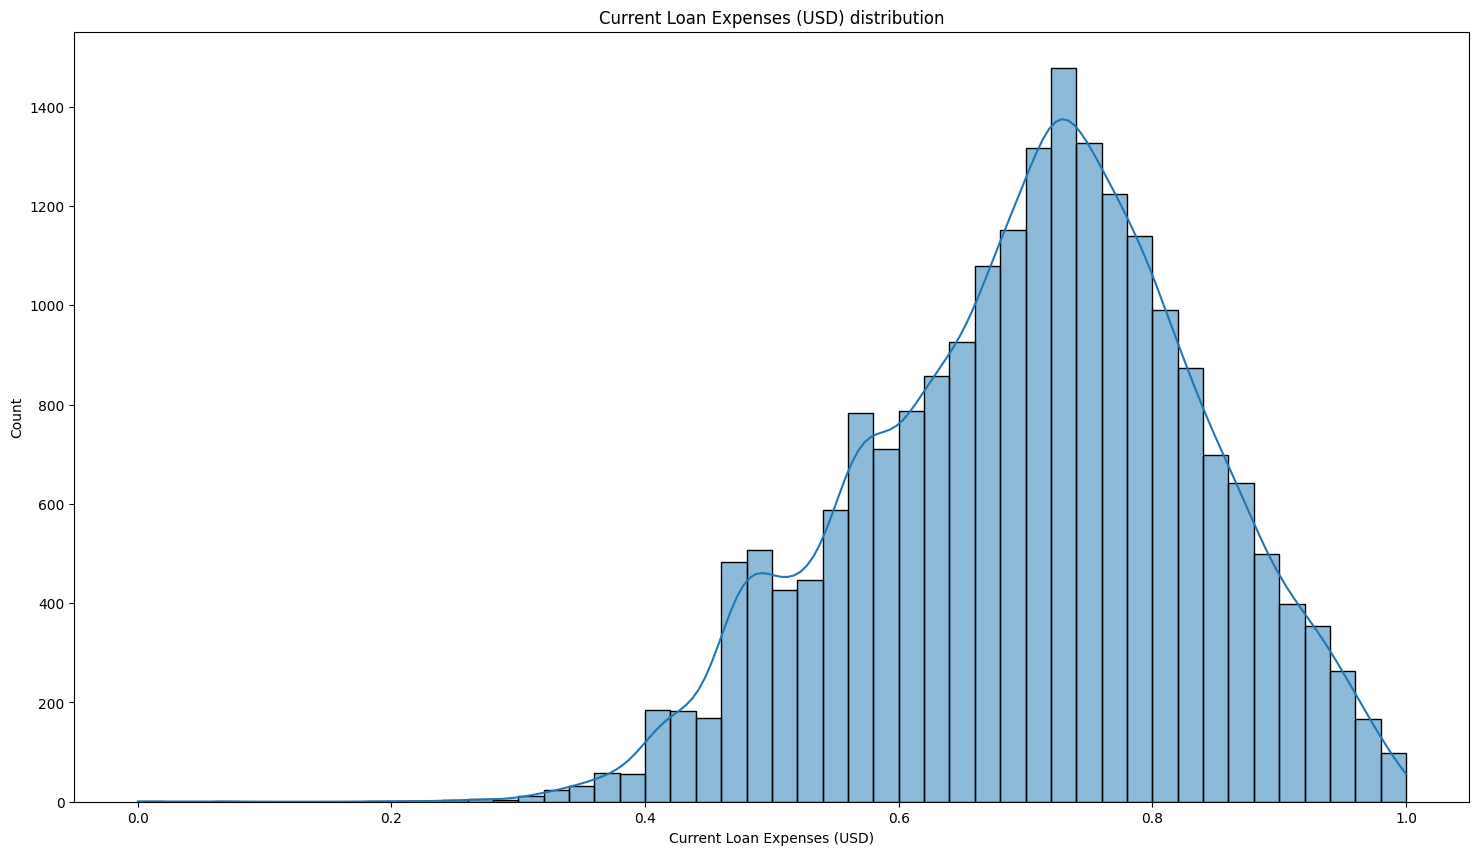

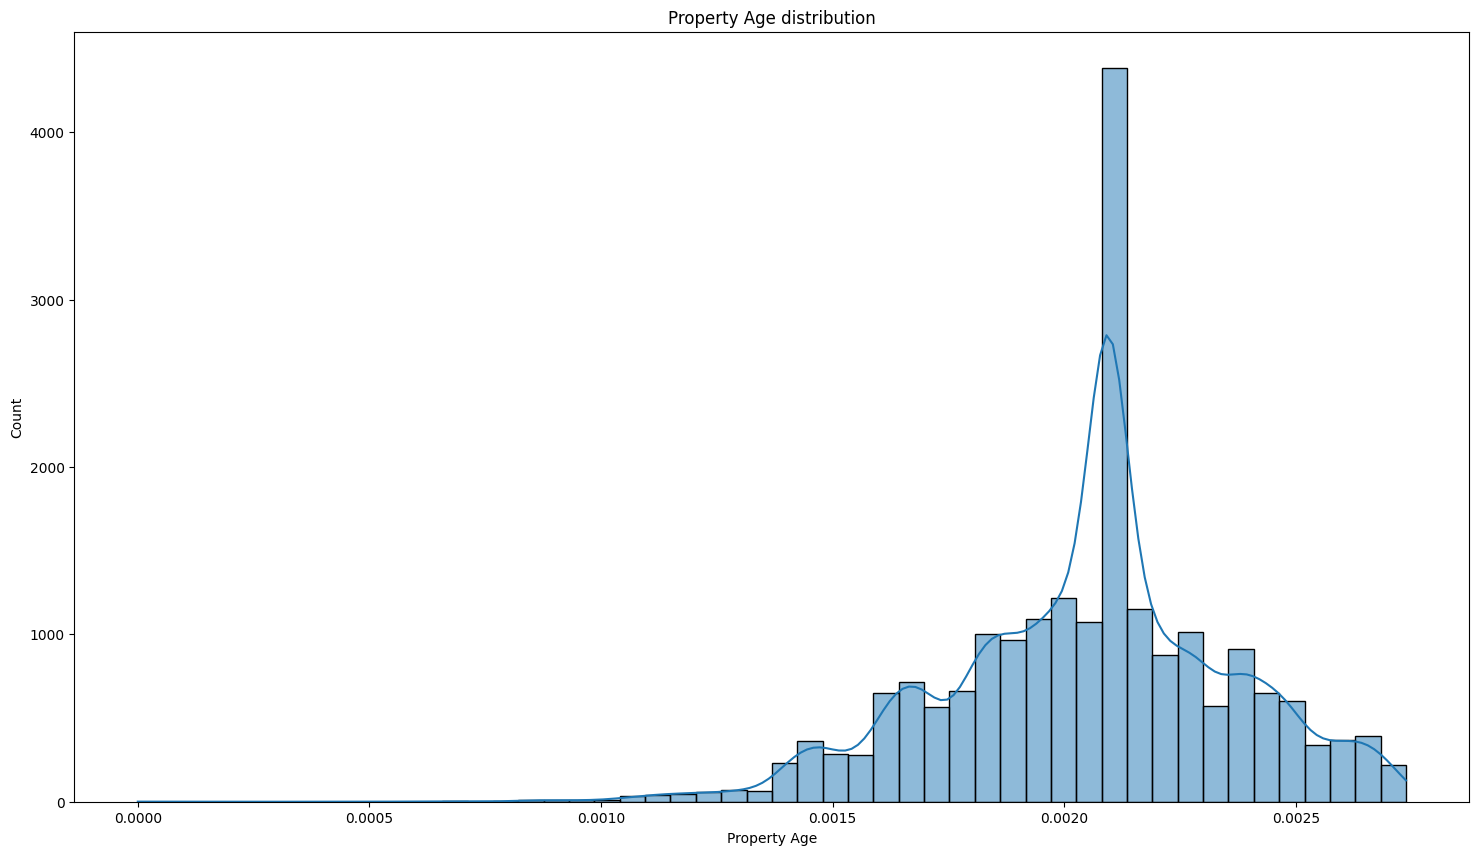

In [67]:
skew_correction(df2, np.cbrt)

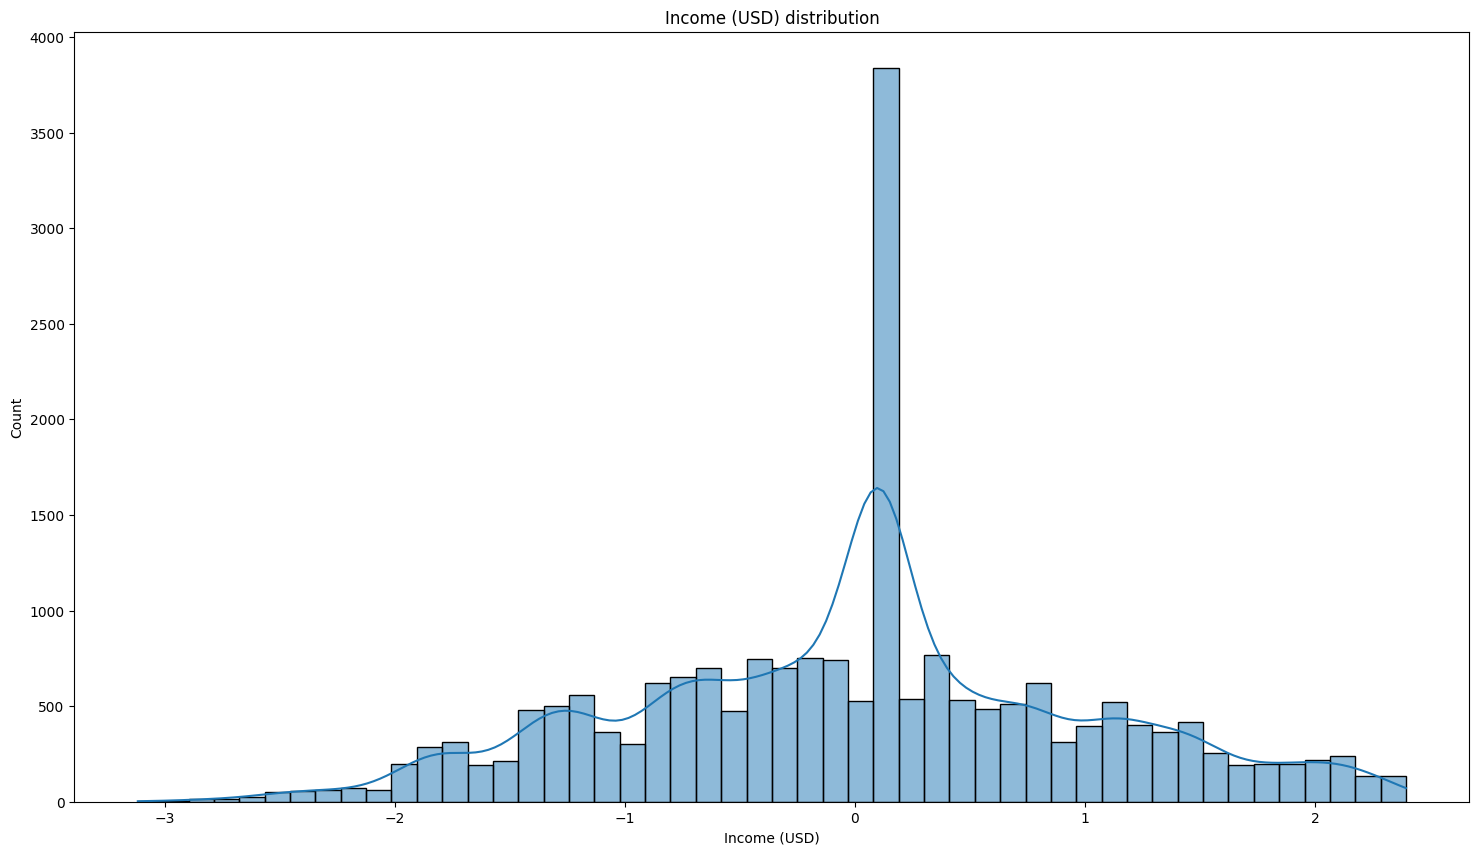

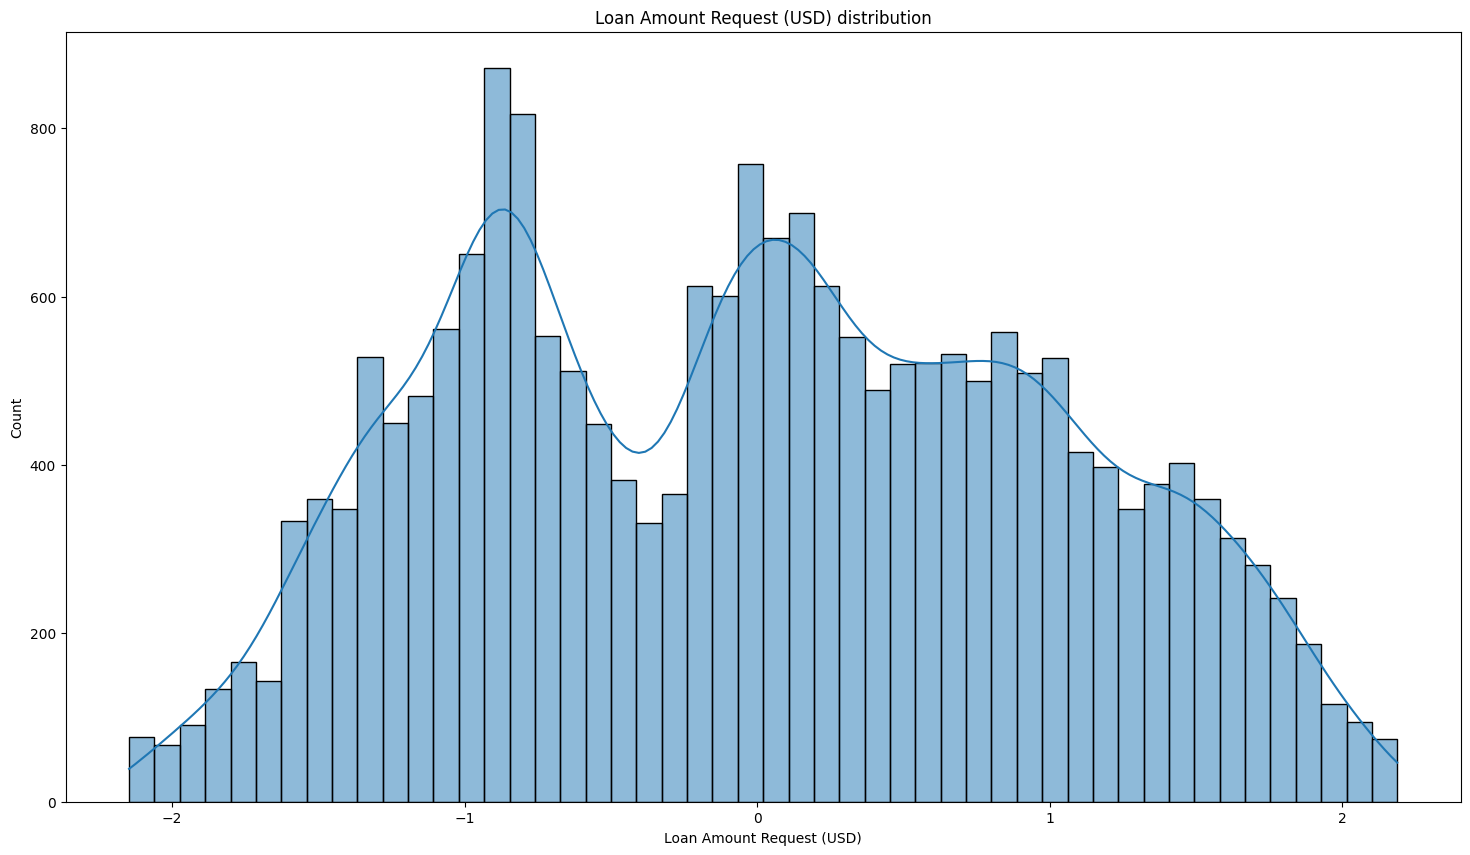

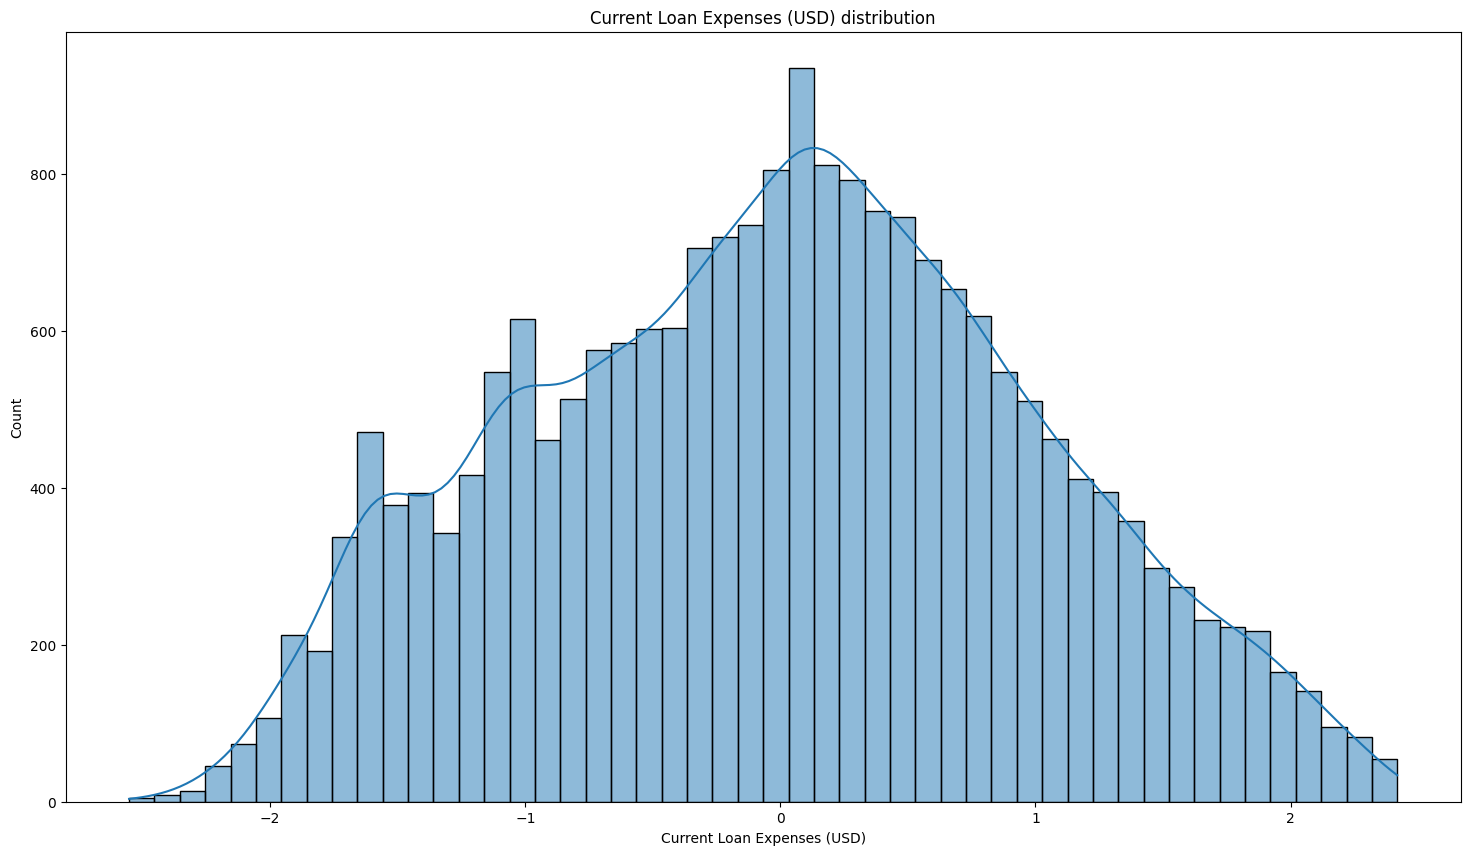

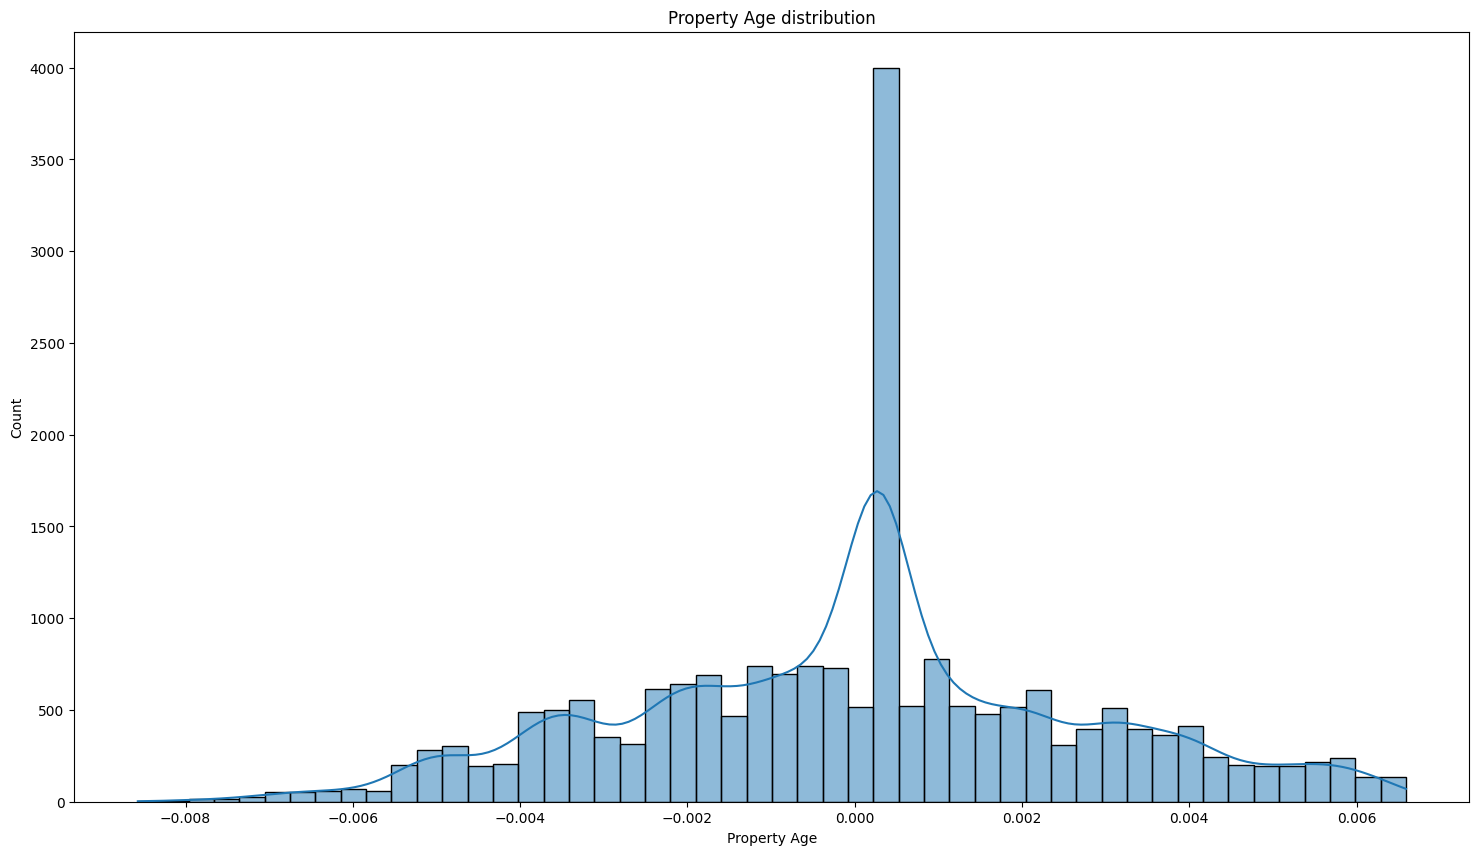

In [68]:
# box-cox transformation
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

skew_correction(df2, pt.fit_transform)


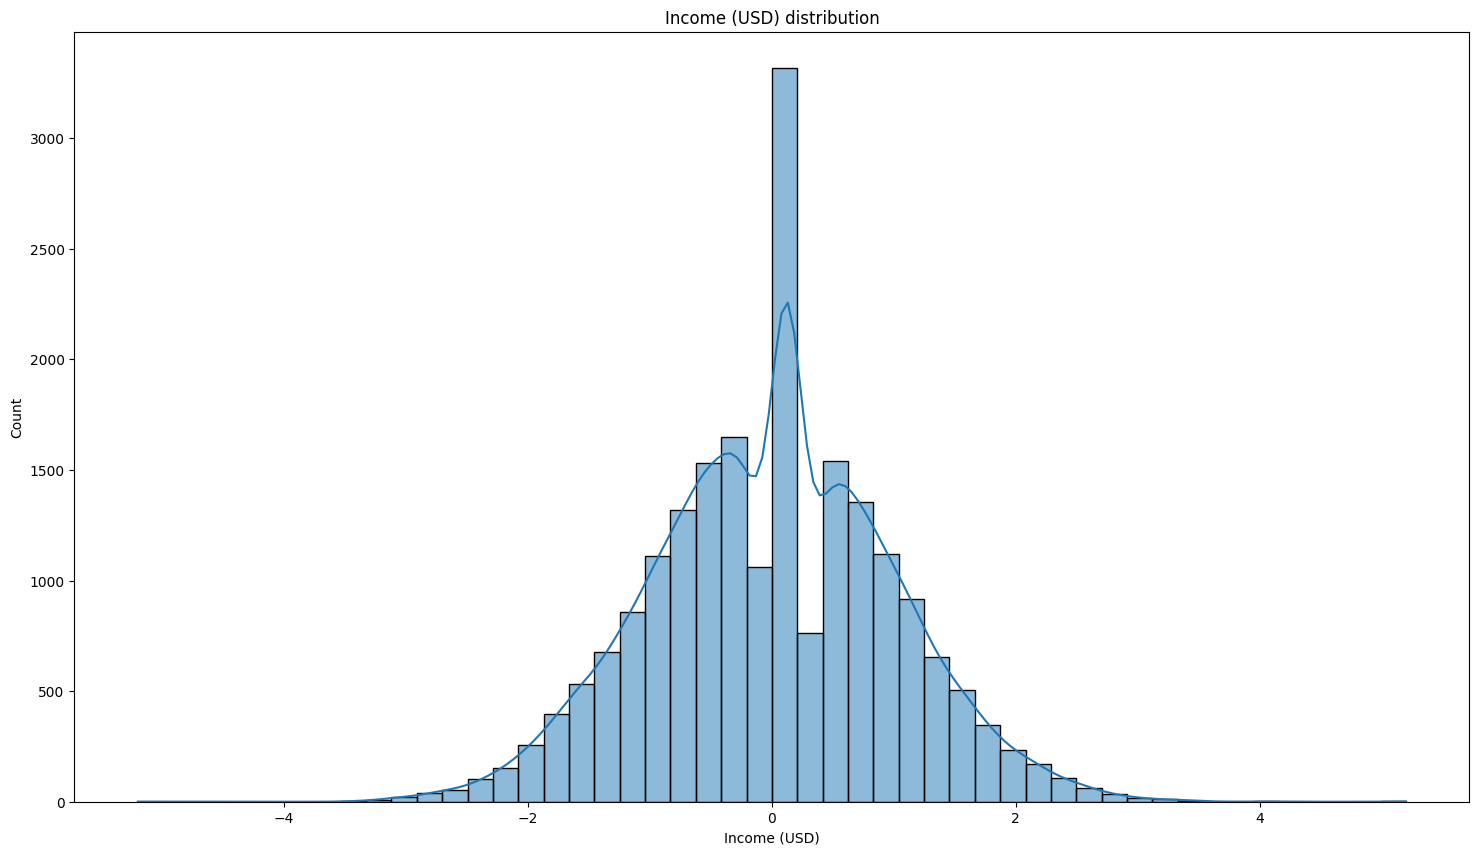

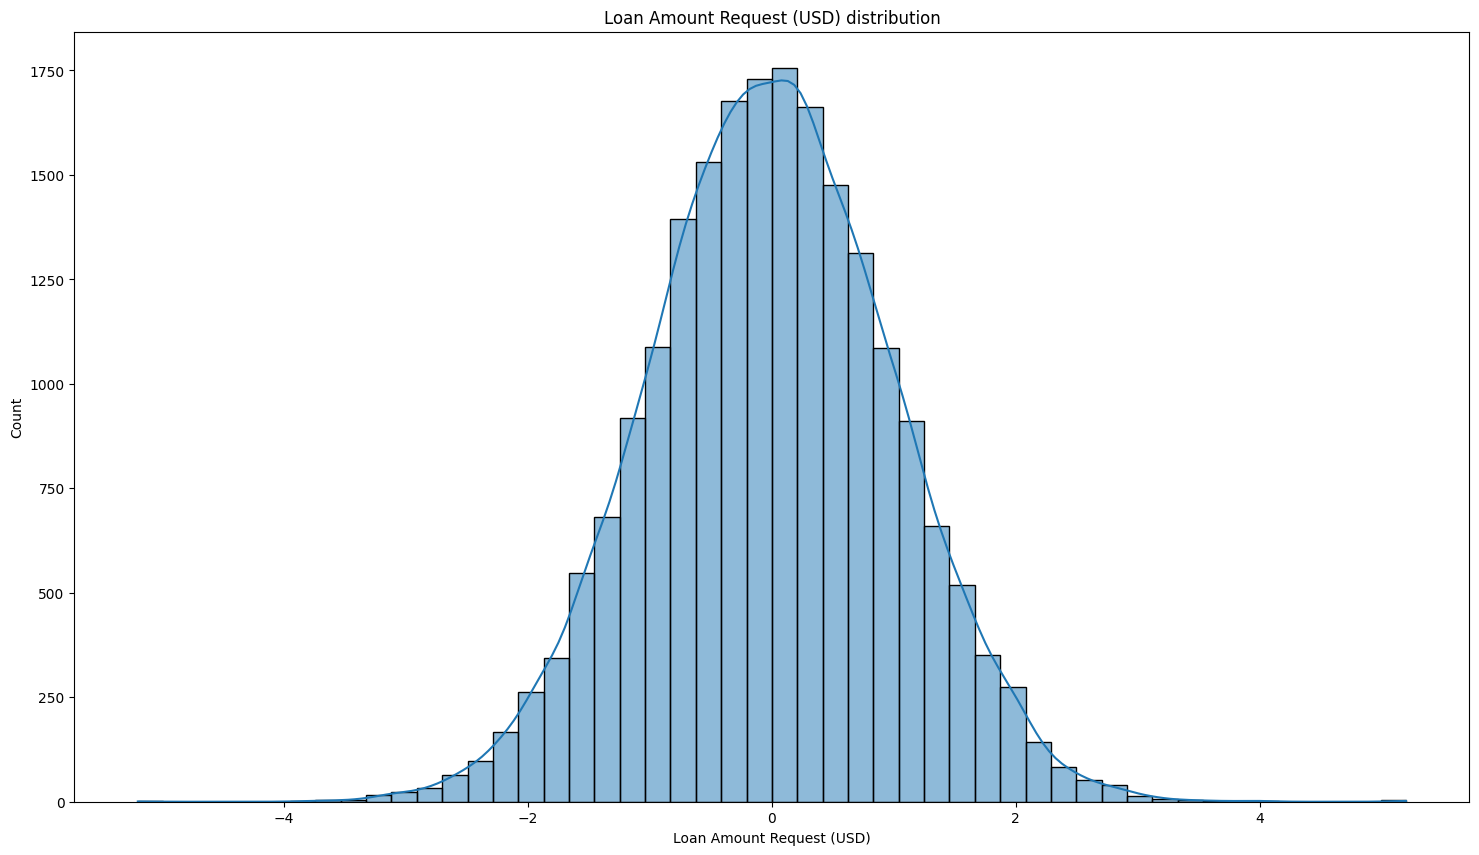

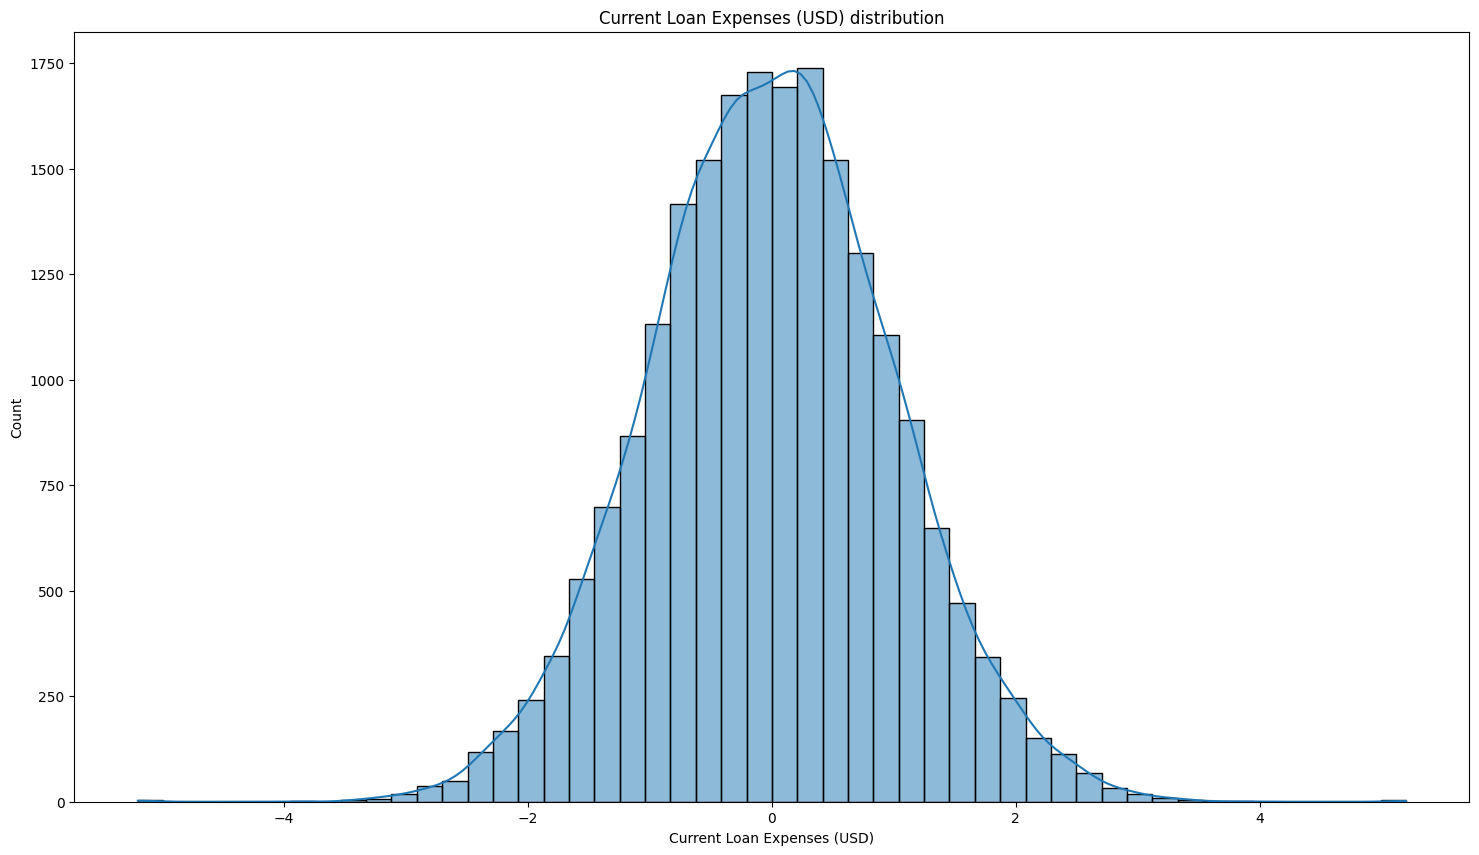

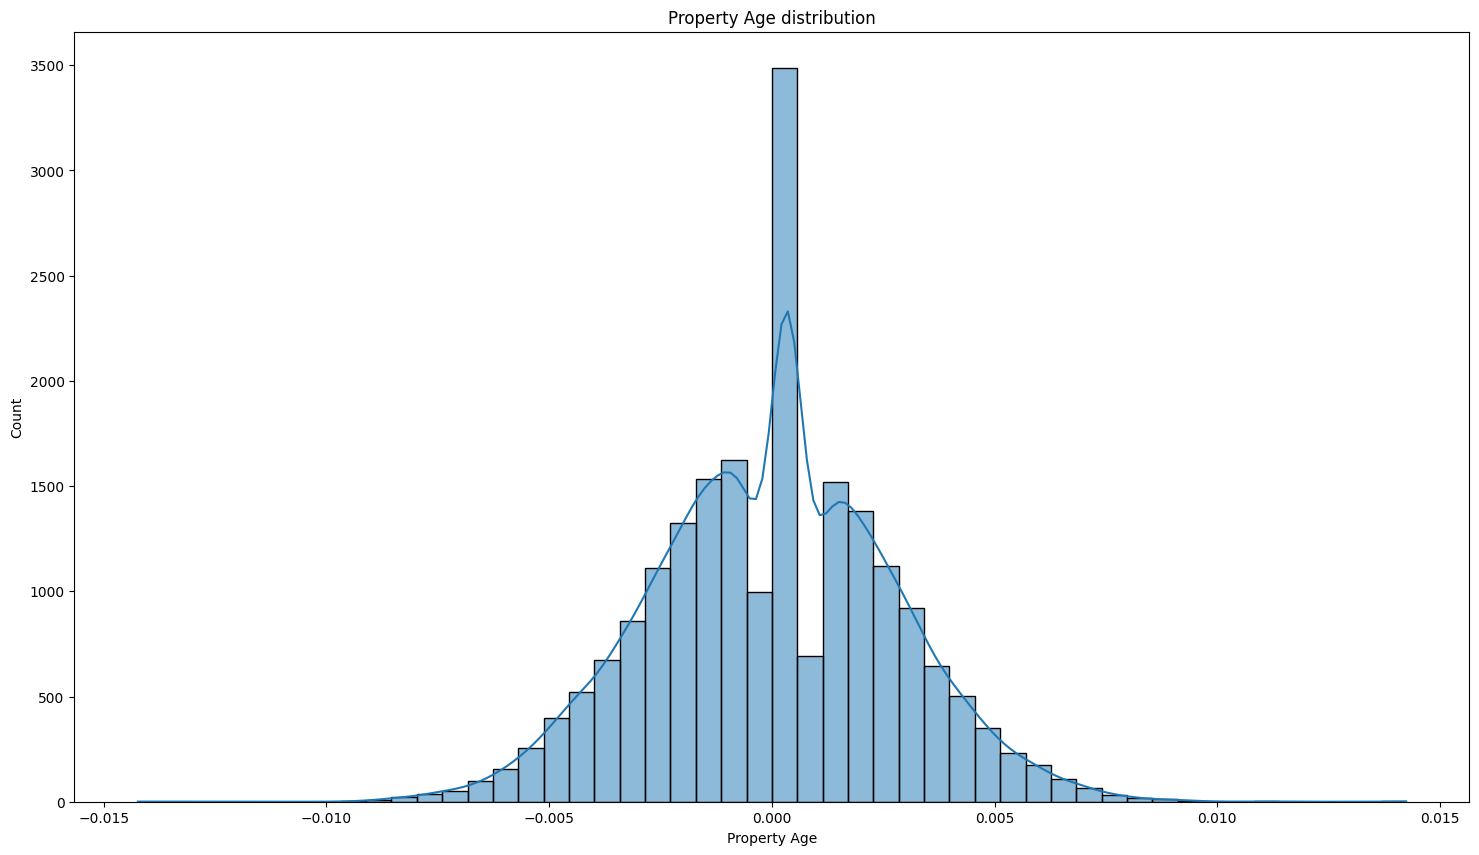

In [69]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')

skew_correction(df2, qt.fit_transform)

Note: 
- Out of all the transformation, box cox performs the best, thus we will be using it.

In [70]:
from sklearn.preprocessing import PowerTransformer

# 1. Initialize the transformer
pt = PowerTransformer(method='yeo-johnson')

def skew_correction(df, transformer_func):
    df = df.copy()
    skewed_cols = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Property Age']
    
    # Apply the function and re-assign to the same columns
    # This ensures the result stays a DataFrame and matches the original index
    df[skewed_cols] = transformer_func(df[skewed_cols])
    
    return df

# 2. Training Data: Fit AND Transform
# Use pt.fit_transform here
df1 = skew_correction(df1, pt.fit_transform)

vdf2 = vdf1.copy()

# 3. Validation Data: Transform ONLY
# Use pt.transform here
vdf2 = skew_correction(vdf1, pt.transform)

**Yeo-Johnson (PowerTransformer) method:**
- **Optimal Normalization:** It automatically finds the best mathematical power ($\lambda$) to make each specific feature distribution symmetrical.

- **Zero-Value Support:** Unlike standard Box-Cox, it handles zeros and negative values without requiring manual data offsets ($x+1$).
- Preserves Data Gaps: It maintains the relative distance and variance between data points better than rank-based methods like QuantileTransformer.

- **Consistent Pipeline:** It saves the transformation rules from your training set to apply identically to validation or production data, preventing data leakage.

- **Algorithm Ready:** It centers and scales data into a Gaussian-like shape, which is a core requirement for many machine learning models to converge accurately.

In [71]:
df1.head()

,Gender,Age,Income (USD),Income Stability,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD),loan_approval,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban
251,1,0.382979,0.102658,1,1.131945,0.798718,0,0,1.000000,0.208847,1,0.102042,3,1,0.702683,0.000000,1,0,0,1,1,0,0,0,0,1
22941,1,0.723404,0.102658,1,0.827387,0.983538,0,1,1.000000,0.399734,0,0.102042,2,1,0.443200,72999.900000,0,0,0,0,1,0,0,0,0,0
618,0,0.000000,0.102658,1,-1.385492,-1.303359,0,0,2.000000,0.190445,0,0.102042,2,1,0.085544,0.000000,1,0,0,1,0,0,0,1,0,1
17090,0,0.000000,0.067012,1,0.134223,1.592628,0,1,2.000000,0.808038,0,0.064938,3,1,0.399286,57256.530000,0,0,0,1,1,0,1,0,0,1
6362,0,0.000000,0.911590,1,0.517041,2.064079,0,1,2.000000,0.572946,0,0.913900,2,1,0.408542,0.000000,1,0,1,0,0,0,0,1,0,1


In [72]:
vdf2.head()

,Gender,Age,Income (USD),Income Stability,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD),loan_approval,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban
2308,1,0.638298,0.598006,1,-0.122626,0.891258,1,1,4.000000,0.210681,0,0.598604,3,1,0.202447,0.000000,1,0,0,1,1,0,0,1,0,1
22404,0,0.851064,2.341039,1,0.399919,0.230306,1,1,3.000000,0.383134,0,2.352502,1,1,0.298762,62192.620000,0,0,0,0,0,1,0,1,1,0
23397,1,0.148936,-0.814773,1,1.274613,0.694451,0,1,2.000000,0.296971,1,-0.820678,4,1,0.508645,99950.540000,0,0,0,0,1,0,1,0,0,1
25058,0,0.000000,0.054770,1,0.939788,0.455473,0,1,3.000000,0.095902,0,0.051674,2,1,0.599248,0.000000,1,0,0,0,1,0,1,0,0,0
2664,0,0.382979,-0.806440,1,-0.583813,-0.742873,0,1,3.000000,0.468254,0,-0.812312,4,1,0.208033,0.000000,1,0,0,1,1,0,0,1,0,0


### Seperating the data from training classiication model vs regression model

- In classification model we do not require 'Loan Sanction Amount' as the dependent variable
- In regression model, we dont require 'loan_approval' as the dependent variable

In [ ]:
# calculate vif

def calculate_vif(df, target_col=None):
    """
    Calculate Variance Inflation Factor (VIF) for each numeric column in df.
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])

    # Add constant for statsmodels
    X = add_constant(numeric_df)

    # Compute VIF (skip the first column = constant)
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i + 1)  # skip constant at index 0
        for i in range(len(numeric_df.columns))
    ]

    return vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

In [80]:
vif_table = calculate_vif(df1, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature        VIF
0                         Income (USD) 102.426092
1                         Property Age 102.215950
2                 Profession_Pensioner  15.564151
3                     Income Stability  14.748536
4            Loan Amount Request (USD)   8.844709
5                       Property Price   6.525585
6          Current Loan Expenses (USD)   2.973463
7                        loan_approval   1.532613
8                   Profession_Working   1.448129
9                       Location_Urban   1.423225
10                        Co-Applicant   1.380150
11                        Credit Score   1.370903
12                 Location_Semi-Urban   1.346167
13        Property Location_Semi-Urban   1.331674
14             Property Location_Urban   1.331333
15                                 Age   1.288044
16  Has Active Credit Card_Unpossessed   1.267439
17     Has Active Credit Card_Inactive   1.265737
18            Profession_State servant   1.213822


inference:
- general rule of vif:
    * VIF = 1: No correlation.
    * VIF 1 to 5: Moderate correlation (usually acceptable).
    * VIF > 5 to 10: High correlation (may be problematic).
    * VIF > 10: Severe multicollinearity. The variables are redundant and will likely make your model coefficients unstable.

based on the above information, we find that we have 6 features to consider: Income(USD), Property Age, Profession Pensioner, Income Stability, Loan Amount Request and property price.
 - Priority to consider: 
    * First: Income(USD), Property Age
    * Second: Profession Pensioner, Income Stability
    * Third: Loan Amount Request and property price

#### **Handling First: Income(USD) or Property Age **

Here we will experiment and observe what result does removing one highly correlated feature feature at a time results in

In [88]:
df3= df1.copy()
df3.drop(columns= 'Income (USD)', axis =1, inplace= True)

vif_table = calculate_vif(df3, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature       VIF
0                 Profession_Pensioner 15.560707
1                     Income Stability 14.743481
2            Loan Amount Request (USD)  8.844271
3                       Property Price  6.525236
4          Current Loan Expenses (USD)  2.971191
5                        loan_approval  1.532204
6                   Profession_Working  1.448127
7                       Location_Urban  1.423023
8                         Co-Applicant  1.380045
9                         Credit Score  1.370873
10                 Location_Semi-Urban  1.346115
11        Property Location_Semi-Urban  1.331664
12             Property Location_Urban  1.331283
13                                 Age  1.288025
14  Has Active Credit Card_Unpossessed  1.267426
15     Has Active Credit Card_Inactive  1.265716
16                        Property Age  1.231955
17            Profession_State servant  1.213609
18                          Dependents  1.052325
19                  

In [95]:
df3= df1.copy()
df3.drop(columns= 'Property Age', axis =1, inplace= True)

vif_table = calculate_vif(df3, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature       VIF
0                 Profession_Pensioner 15.559197
1                     Income Stability 14.743874
2            Loan Amount Request (USD)  8.843805
3                       Property Price  6.525174
4          Current Loan Expenses (USD)  2.973304
5                        loan_approval  1.532138
6                   Profession_Working  1.448053
7                       Location_Urban  1.423204
8                         Co-Applicant  1.380013
9                         Credit Score  1.370880
10                 Location_Semi-Urban  1.346159
11        Property Location_Semi-Urban  1.331667
12             Property Location_Urban  1.331305
13                                 Age  1.288030
14  Has Active Credit Card_Unpossessed  1.267421
15     Has Active Credit Card_Inactive  1.265718
16                        Income (USD)  1.234488
17            Profession_State servant  1.213690
18                          Dependents  1.052270
19                  

Inference: 
- Dropping one caused the VIF of the other to plummet to around 1.2. This confirms they were almost perfectly correlated.

- Between the two, keep Income (USD) and drop Property Age. In financial modeling, income is usually a much stronger predictor of loan behavior than the age of the property.

- Now, we need to address your next "VIF cluster": Profession Pensioner, Income Stability

In [96]:
df4= df3.copy()
df4.drop(columns= 'Profession_Pensioner', axis =1, inplace= True)

vif_table = calculate_vif(df4, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature      VIF
0            Loan Amount Request (USD) 8.843176
1                       Property Price 6.525170
2          Current Loan Expenses (USD) 2.972566
3                     Income Stability 1.704443
4                        loan_approval 1.526541
5                   Profession_Working 1.425069
6                       Location_Urban 1.421998
7                         Co-Applicant 1.367818
8                         Credit Score 1.367208
9                  Location_Semi-Urban 1.346030
10        Property Location_Semi-Urban 1.331617
11             Property Location_Urban 1.331305
12  Has Active Credit Card_Unpossessed 1.267390
13     Has Active Credit Card_Inactive 1.265709
14                                 Age 1.264050
15                        Income (USD) 1.233651
16            Profession_State servant 1.206478
17                      Expense Type 1 1.051395
18                          Dependents 1.051069
19                      Expense Type 2 1

In [97]:
df4= df3.copy()
df4.drop(columns= 'Income Stability', axis =1, inplace= True)

vif_table = calculate_vif(df4, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature      VIF
0            Loan Amount Request (USD) 8.843772
1                       Property Price 6.525136
2          Current Loan Expenses (USD) 2.973246
3                 Profession_Pensioner 1.798697
4                        loan_approval 1.530666
5                   Profession_Working 1.448053
6                       Location_Urban 1.423193
7                         Co-Applicant 1.379702
8                         Credit Score 1.370571
9                  Location_Semi-Urban 1.346157
10        Property Location_Semi-Urban 1.331634
11             Property Location_Urban 1.331305
12                                 Age 1.288030
13  Has Active Credit Card_Unpossessed 1.267320
14     Has Active Credit Card_Inactive 1.265661
15                        Income (USD) 1.234415
16            Profession_State servant 1.213690
17                          Dependents 1.052269
18                      Expense Type 1 1.051763
19                      Expense Type 2 1

Inference: 

Again, similar results 
- The "Pensioner vs. Stability" Conflict: The data shows that Profession_Pensioner and Income Stability were essentially carrying the same information. By removing one, the other becomes a clean, independent signal.

- We will drop Profession_Pensioner and keep Income Stability. Income Stability is a more "universal" feature. It likely captures whether income is steady for everyone (Working, State Servant, and Pensioners), whereas Profession_Pensioner only describes one specific group. Keeping the stability metric usually provides more predictive power for the model.

Now moving on to the third VIF cluster: Loan Amount Request and property price.

- In both results, Loan Amount Request (8.8) and Property Price (6.5) are the highest remaining VIFs. Since they are under 10, they are acceptable, though they are closely linked (which makes sense—bigger houses need bigger loans).

- Since Loan Amount Request and Property Price still have higher VIFs (6–8), we can create a Loan-to-Value (LTV) Ratio. This will helps models understand the risk better than the raw numbers.

In [104]:
vif_table = calculate_vif(df5, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature      VIF
0            Loan Amount Request (USD) 8.843176
1                       Property Price 6.525170
2          Current Loan Expenses (USD) 2.972566
3                     Income Stability 1.704443
4                        loan_approval 1.526541
5                   Profession_Working 1.425069
6                       Location_Urban 1.421998
7                         Co-Applicant 1.367818
8                         Credit Score 1.367208
9                  Location_Semi-Urban 1.346030
10        Property Location_Semi-Urban 1.331617
11             Property Location_Urban 1.331305
12  Has Active Credit Card_Unpossessed 1.267390
13     Has Active Credit Card_Inactive 1.265709
14                                 Age 1.264050
15                        Income (USD) 1.233651
16            Profession_State servant 1.206478
17                      Expense Type 1 1.051395
18                          Dependents 1.051069
19                      Expense Type 2 1

In [102]:
# 1. Check for NaNs
print("Missing values per column:")
print(df5.isnull().sum().sum()) 

# 2. Check for Infinite values
import numpy as np
print("Infinite values per column:")
print(np.isinf(df5.select_dtypes(include=np.number)).sum().sum())

Missing values per column:
0
Infinite values per column:
254


In [106]:
# Option 1: The direct fix
df1['Property Price'][df1['Property Price'] == 0].value_counts()

Property Price
0.000000    254
Name: count, dtype: int64

- In one of the earlier steps, the property price had placeholder value of -999 which was replaced by 0. instead of 0 now, we can replace it to nan and then to median value.

- Property prices are usually tied to the Loan Amount Request. Instead of just using the overall median, you can fill the missing prices based on the average relationship between loan amounts and property values.

In [ ]:
df5 = df1.copy()

vdf3 = vdf2.copy()

def property_price_transform(df):

    df = df.copy()

    df['Property Price'] = df['Property Price'].replace(0, np.nan)

    median_price = df['Property Price'].median()
    df['Property Price'] = df['Property Price'].fillna(median_price)

    return df

df5 = property_price_transform(df5)

vdf3 = property_price_transform(vdf3)


In [116]:
def vif_transform(df):
    df = df.copy()
    
    df['LTV_Ratio'] = df['Loan Amount Request (USD)'] / df['Property Price']

    cols_to_drop = ['Property Age', 'Profession_Pensioner', 'Loan Amount Request (USD)', 'Property Price']
    df = df.drop(columns=cols_to_drop)

    return df

df6 = df5.copy()
vdf4 = vdf3.copy()

df6 = vif_transform(df6)
vdf4 = vif_transform(vdf4)

df6.head(2)

,Gender,Age,Income (USD),Income Stability,Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Type,Co-Applicant,Loan Sanction Amount (USD),loan_approval,Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban,LTV_Ratio
251,1,0.382979,0.102658,1,0.798718,0,0,1.000000,0.208847,1,3,1,0.000000,1,0,1,1,0,0,0,0,1,1.610889
22941,1,0.723404,0.102658,1,0.983538,0,1,1.000000,0.399734,0,2,1,72999.900000,0,0,0,1,0,0,0,0,0,1.866849


In [117]:
vif_table = calculate_vif(df6, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature      VIF
0          Current Loan Expenses (USD) 1.856866
1                     Income Stability 1.703774
2                            LTV_Ratio 1.700711
3                        loan_approval 1.525932
4                   Profession_Working 1.425017
5                       Location_Urban 1.420722
6                         Co-Applicant 1.368269
7                         Credit Score 1.350848
8                  Location_Semi-Urban 1.346054
9         Property Location_Semi-Urban 1.331418
10             Property Location_Urban 1.331027
11  Has Active Credit Card_Unpossessed 1.266734
12     Has Active Credit Card_Inactive 1.265994
13                                 Age 1.263977
14                        Income (USD) 1.232789
15            Profession_State servant 1.204695
16                      Expense Type 1 1.050828
17                          Dependents 1.050385
18                      Expense Type 2 1.012801
19                     No. of Defaults 1

In [118]:
vif_table = calculate_vif(vdf4, target_col='Loan Sanction Amount (USD)')
print(vif_table)

                               feature      VIF
0          Current Loan Expenses (USD) 1.890038
1                            LTV_Ratio 1.735412
2                     Income Stability 1.705416
3                        loan_approval 1.509099
4                   Profession_Working 1.480624
5                       Location_Urban 1.431421
6                         Co-Applicant 1.351915
7                  Location_Semi-Urban 1.349946
8         Property Location_Semi-Urban 1.347515
9              Property Location_Urban 1.345996
10                        Credit Score 1.344089
11     Has Active Credit Card_Inactive 1.273508
12  Has Active Credit Card_Unpossessed 1.270406
13                                 Age 1.257580
14                        Income (USD) 1.249299
15            Profession_State servant 1.244767
16                          Dependents 1.051361
17                      Expense Type 1 1.041878
18                      Expense Type 2 1.020957
19                       Property Type 1

In [119]:
## For classification models

# training dataset
df_classification = df6.copy()

df_classification.drop(columns='Loan Sanction Amount (USD)', axis=1, inplace=True)

# testing dataset

vdf_classification = vdf4.copy()
vdf_classification.drop(columns='Loan Sanction Amount (USD)', axis=1, inplace=True)

df_classification.head(2)

,Gender,Age,Income (USD),Income Stability,Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Type,Co-Applicant,loan_approval,Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban,LTV_Ratio
251,1,0.382979,0.102658,1,0.798718,0,0,1.000000,0.208847,1,3,1,1,0,1,1,0,0,0,0,1,1.610889
22941,1,0.723404,0.102658,1,0.983538,0,1,1.000000,0.399734,0,2,1,0,0,0,1,0,0,0,0,0,1.866849


In [120]:
vdf_classification.head(2)

,Gender,Age,Income (USD),Income Stability,Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Type,Co-Applicant,loan_approval,Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban,LTV_Ratio
2308,1,0.638298,0.598006,1,0.891258,1,1,4.000000,0.210681,0,3,1,1,0,1,1,0,0,1,0,1,-0.605717
22404,0,0.851064,2.341039,1,0.230306,1,1,3.000000,0.383134,0,1,1,0,0,0,0,1,0,1,1,0,1.338584


In [ ]:
df_classification.to_csv(r"C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\data\feature_engineered\train_classification_data.csv", index=False)

vdf_classification.to_csv(r"C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\data\feature_engineered\test_classification_data.csv", index=False)

In [123]:
# for regression model 

# train dataset
df_regression = df6.copy()

df_regression = df_regression[df_regression['Loan Sanction Amount (USD)'] !=0]
df_regression.drop(columns='loan_approval', axis=1, inplace=True)
df_regression.head(5)

,Gender,Age,Income (USD),Income Stability,Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Type,Co-Applicant,Loan Sanction Amount (USD),Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban,LTV_Ratio
22941,1,0.723404,0.102658,1,0.983538,0,1,1.000000,0.399734,0,2,1,72999.900000,0,0,1,0,0,0,0,0,1.866849
17090,0,0.000000,0.067012,1,1.592628,0,1,2.000000,0.808038,0,3,1,57256.530000,0,1,1,0,1,0,0,1,0.336157
24680,1,0.000000,0.102658,1,1.656502,1,1,1.000000,0.881458,0,2,1,53477.840000,0,0,0,1,0,0,0,0,0.053696
15874,0,1.000000,0.102658,0,0.586484,1,1,2.000000,0.396983,0,2,1,45719.190000,0,0,1,0,0,0,1,0,-0.376144
22653,1,0.021277,-0.228684,1,-0.562925,0,1,3.000000,0.232024,0,3,1,36144.500000,0,1,1,0,1,0,1,0,-1.342388


In [124]:
# test dataset
vdf_regression = vdf4.copy()

vdf_regression = vdf_regression[vdf_regression['Loan Sanction Amount (USD)'] !=0]
vdf_regression.drop(columns='loan_approval', axis=1, inplace=True)
vdf_regression.head(5)

,Gender,Age,Income (USD),Income Stability,Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Property Type,Co-Applicant,Loan Sanction Amount (USD),Profession_State servant,Profession_Working,Location_Semi-Urban,Location_Urban,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Semi-Urban,Property Location_Urban,LTV_Ratio
22404,0,0.851064,2.341039,1,0.230306,1,1,3.000000,0.383134,0,1,1,62192.620000,0,0,0,1,0,1,1,0,1.338584
23397,1,0.148936,-0.814773,1,0.694451,0,1,2.000000,0.296971,1,4,1,99950.540000,0,0,1,0,1,0,0,1,2.505900
5148,0,0.340426,-1.395819,1,0.360964,0,1,2.000000,0.842250,0,1,1,108298.160000,0,0,1,0,0,1,1,0,2.399527
7790,1,0.085106,-0.348959,1,0.148339,1,1,1.000000,0.500316,0,4,1,95849.550000,1,0,1,0,0,0,0,1,2.313700
19043,1,0.000000,-0.296887,1,-1.661689,0,0,1.000000,0.861728,0,3,1,10743.410000,0,1,1,0,1,0,1,0,-25.741494


In [125]:
df_regression.to_csv(r"C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\data\feature_engineered\train_regression_data.csv", index=False)

vdf_regression.to_csv(r"C:\Users\user\Desktop\ML & DL projects\2 Stage loan system\data\feature_engineered\test_regression_data.csv", index=False)